In [1]:
# IMPORTO I DATI PER VOTTIGNASCO
import os
import numpy as np

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

105
105
105


In [49]:
import geopandas as gpd
import xarray
import rioxarray
from skimage.segmentation import slic

work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
shapefile_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/shapefile_raster/")

def create_spatial_superpixels(shapefile_path, n_segments=8, compactness=15):
  # DTM [50m] import
  dtm_piemonte = rioxarray.open_rasterio(shapefile_path + 'DTMPiemonte_filled_50m.tif')
  dtm_piemonte = dtm_piemonte.rio.reproject("epsg:4326")
  dtm_piemonte = dtm_piemonte.where(dtm_piemonte != -99999) # Take valid pixel

  # Catchment shapefile
  catchment = gpd.read_file(shapefile_path + "BAC_01_bacialti.shp") # select GRANA-MAIRA	and VARAITA
  catchment = catchment.to_crs('epsg:4326')

  # Select only the Grana-Maira catchment
  catchment_GM = catchment.loc[catchment.NOME == "GRANA-MAIRA"]
  catchment_GM = catchment_GM.reset_index(drop = True)

  # Retrieve the borders of the catchment from the shapefile
  xmin_clip, ymin_clip, xmax_clip, ymax_clip = catchment_GM.total_bounds
  # Extend the borders to include more pixel on the borders

  increase = 0.05 # Degrees
  #ymin_clip -= increase # not needed
  xmin_clip += increase # "+" for subset for pixel included in the mask
  xmax_clip += increase
  #ymax_clip += increase # not needed

  dtm_piemonte_clipped = dtm_piemonte.rio.clip_box( minx = xmin_clip, maxx= xmax_clip , miny= ymin_clip , maxy= ymax_clip)

  # Creazione img 5x8 cone lat,lon,dtm
  # Definizione delle coordinate
  lon = np.array([6.938, 7.063, 7.188, 7.313, 7.438, 7.563, 7.688, 7.813])  # 8 valori
  lat = np.array([44.313, 44.438, 44.563, 44.688, 44.813])  # 5 valori

  # Creazione di una griglia lat-lon 5x8
  lon_grid, lat_grid = np.meshgrid(lon, lat)

  # Creazione di un array 5x8x3
  img = np.zeros((5, 8, 3))

  # Assegno le coordinate nei primi due canali
  img[:, :, 0] = lat_grid  # Canale 0 = latitudine
  img[:, :, 1] = lon_grid  # Canale 1 = longitudine
  img[:, :, 2] = 0  # Canale 2 = valore placeholder

  for nr_lat,latitude in enumerate(lat):
    for  nr_lon,longitude in enumerate(lon):
      img[nr_lat, nr_lon, 2] = dtm_piemonte_clipped.sel(x=longitude, y=latitude, method='nearest').values

  img = np.nan_to_num(img, nan=0.0)

  # SLIC
  segments = slic(img, n_segments=n_segments, compactness=compactness)

  # Creazione Spatial-Superpixels
  # Trova i valori unici nella matrice (i cluster)
  clusters = np.unique(segments)

  # Creazione di una lista di matrici binarie per ogni cluster
  binary_matrices = {}

  for cluster in clusters:
      binary_matrices[cluster] = (segments == cluster).astype(int)

  spatial_superpixels = [matrix for _, matrix in binary_matrices.items()]

  spatial_superpixel_clusters = []

  for ss in spatial_superpixels:
    indices = np.argwhere(ss == 1)
    cluster_pixels = [(x, y) for x, y in indices]
    spatial_superpixel_clusters.append(cluster_pixels)

  return spatial_superpixels, spatial_superpixel_clusters, segments

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

def plot_combined_curves(all_errors_insertion, all_errors_deletion, title="", save_path=""):
    # Creazione della figura e dei due subplot (1 riga, 2 colonne)
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    # Plot per la curva di inserimento
    max_len_insertion = max(map(len, all_errors_insertion))
    padded_array_insertion = np.full((len(all_errors_insertion), max_len_insertion), np.nan)
    for i, row in enumerate(all_errors_insertion):
        padded_array_insertion[i, :len(row)] = row  # Riempie solo le parti esistenti
    #mean_errors_for_insertion_vott = np.nanmean(all_errors_insertion, axis=0)
    mean_errors_for_insertion_vott = np.nanmean(padded_array_insertion, axis=0)

    #x_insertion = np.arange(0, mean_errors_for_insertion_vott.shape[0])
    x_insertion = np.linspace(0, 1, mean_errors_for_insertion_vott.shape[0])
    auc_insertion = calculate_auc(x_insertion, mean_errors_for_insertion_vott)
    auc_text_insertion = f'AUC = {auc_insertion:.2f}'
    axs[0].plot(x_insertion, mean_errors_for_insertion_vott, label=f'Error Curve, {auc_text_insertion}')
    #axs[0].scatter(x_insertion, mean_errors_for_insertion_vott, color='blue', zorder=3)


    axs[0].fill_between(x_insertion, mean_errors_for_insertion_vott, color='skyblue', alpha=0.4)
    axs[0].set_xlabel('Fraction of pixels inserted')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_title('Mean Insertion Metric Curve')
    axs[0].legend()

    # Plot per la curva di cancellazione
    max_len_deletion = max(map(len, all_errors_deletion))
    padded_array_deletion = np.full((len(all_errors_deletion), max_len_deletion), np.nan)
    for i, row in enumerate(all_errors_deletion):
        padded_array_deletion[i, :len(row)] = row  # Riempie solo le parti esistenti
    mean_errors_for_deletion_vott = np.nanmean(padded_array_deletion, axis=0)
    #mean_errors_for_deletion_vott = np.nanmean(all_errors_deletion, axis=0)

    #x_deletion = np.arange(0, mean_errors_for_deletion_vott.shape[0])
    x_deletion = np.linspace(0, 1, mean_errors_for_deletion_vott.shape[0])
    auc_deletion = calculate_auc(x_deletion, mean_errors_for_deletion_vott)
    auc_text_deletion = f'AUC = {auc_deletion:.2f}'

    axs[1].plot(x_deletion, mean_errors_for_deletion_vott, label=f'Error Curve, {auc_text_deletion}')
    #axs[1].scatter(x_deletion, mean_errors_for_deletion_vott, color='red', zorder=3)
    axs[1].fill_between(x_deletion, mean_errors_for_deletion_vott, color='lightcoral', alpha=0.4)
    axs[1].set_xlabel('Fraction of pixels removed')
    axs[1].set_ylabel('Mean Squared Error')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_title('Deletion Mean Metric Curve')
    axs[1].legend()

    # Aggiungi il titolo globale
    plt.suptitle(title, fontsize=16)
    # Mostra i plot
    plt.tight_layout()

    # Salva la figura con DPI 400
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)  # Per evitare che il titolo si sovrapponga ai grafici
    #plt.savefig(save_path, dpi=400)

    plt.show()

    return auc_insertion, auc_deletion

In [31]:
import matplotlib.pyplot as plt

def plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion):
    """
    Plotta due scatter plot affiancati (1x2) per confrontare le AUC delle metriche insertion e deletion.

    Args:
    - all_param_auc_insertion (list): Lista di tuple/liste [AUC, configurazione] per insertion.
    - all_param_auc_deletion (list): Lista di tuple/liste [AUC, configurazione] per deletion.
    """

    # Separare le AUC e le configurazioni per insertion
    auc_values_insertion = [item[0] for item in all_param_auc_insertion]
    configurations_insertion = [item[1] for item in all_param_auc_insertion]

    # Separare le AUC e le configurazioni per deletion
    auc_values_deletion = [item[0] for item in all_param_auc_deletion]
    configurations_deletion = [item[1] for item in all_param_auc_deletion]

    # Impostare la figura con due subplot affiancati (1x2)
    plt.figure(figsize=(15, 6))

    # Primo subplot: Insertion
    plt.subplot(1, 2, 1)
    plt.scatter(configurations_insertion, auc_values_insertion, color='blue')
    plt.title('AUC Mean Insertion Values')
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    # Secondo subplot: Deletion
    plt.subplot(1, 2, 2)
    plt.scatter(configurations_deletion, auc_values_deletion, color='red')
    plt.title('AUC Mean Deletion Values')
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    # Ottimizzare il layout
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def plot_multiple_auc_comparisons(data, labels=None, title='AUC Comparison for Different Parameters'):
    """
    Plotta uno scatter plot comparativo delle AUC per più combinazioni di parametri.

    Args:
    - data (list of lists): Ogni sotto-lista ha coppie [AUC, configurazione]
    - labels (list): Etichette per ogni serie di dati (opzionale)
    - title (str): Titolo del grafico
    """

    plt.figure(figsize=(12, 6))

    # Se non ci sono labels, crea etichette generiche (Set 1, Set 2, ...)
    if labels is None:
        labels = [f'Set {i+1}' for i in range(len(data))]

    # Iterare sui dati e plottare ciascun set
    for i, auc_param_list in enumerate(data):
        auc_values = [item[0] for item in auc_param_list]
        configurations = [item[1] for item in auc_param_list]
        plt.scatter(configurations, auc_values, label=labels[i])

    # Personalizzazioni del plot
    plt.title(title)
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Parameter Sets")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### *Lime*

In [35]:
total_auc_insertion = []
total_auc_deletion  = []

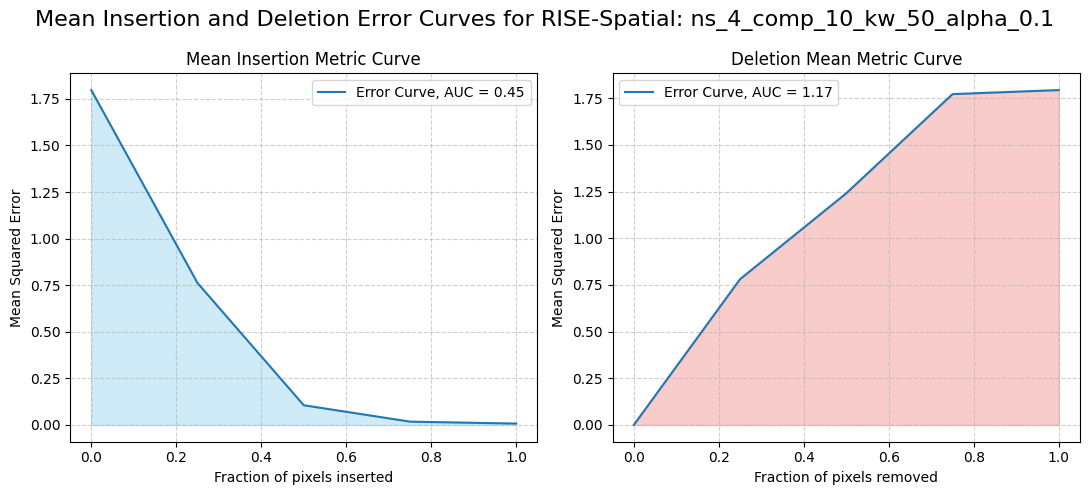

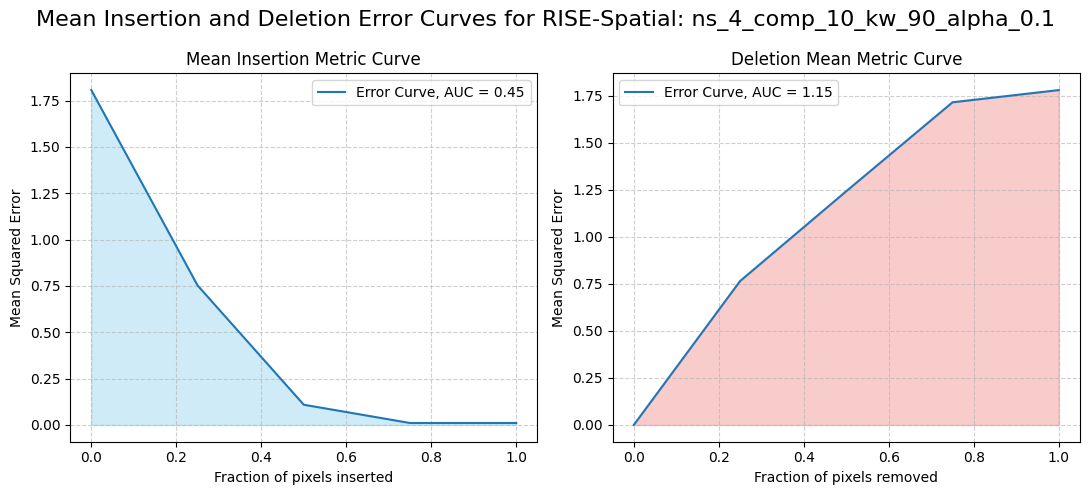

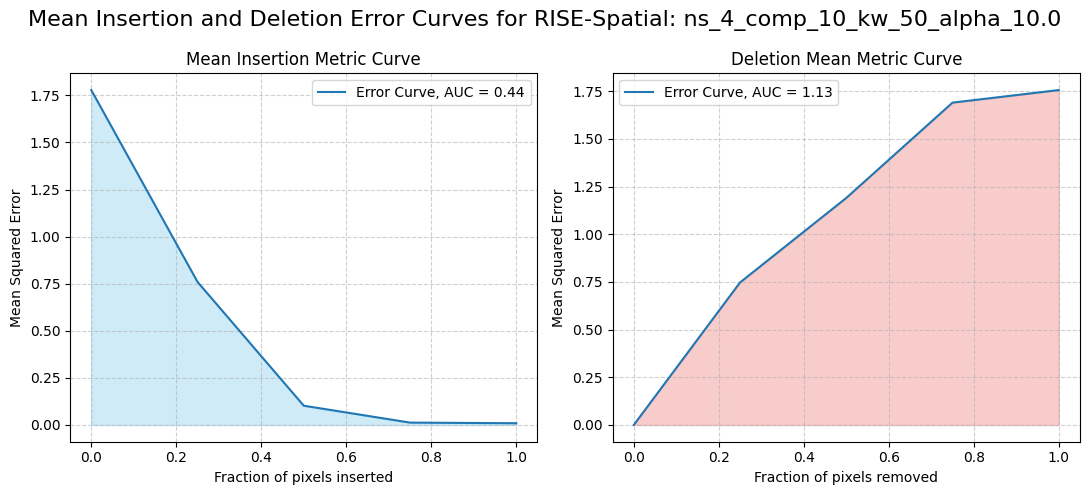

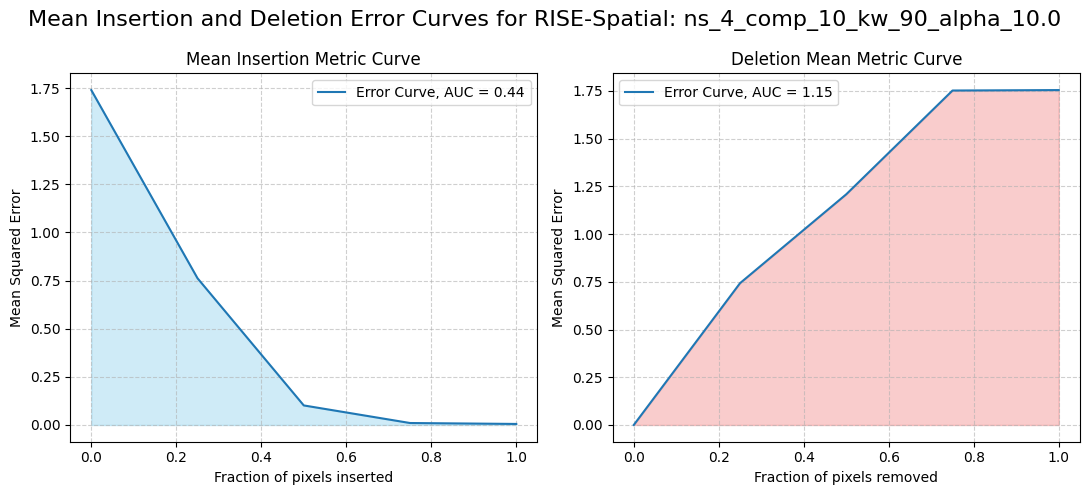

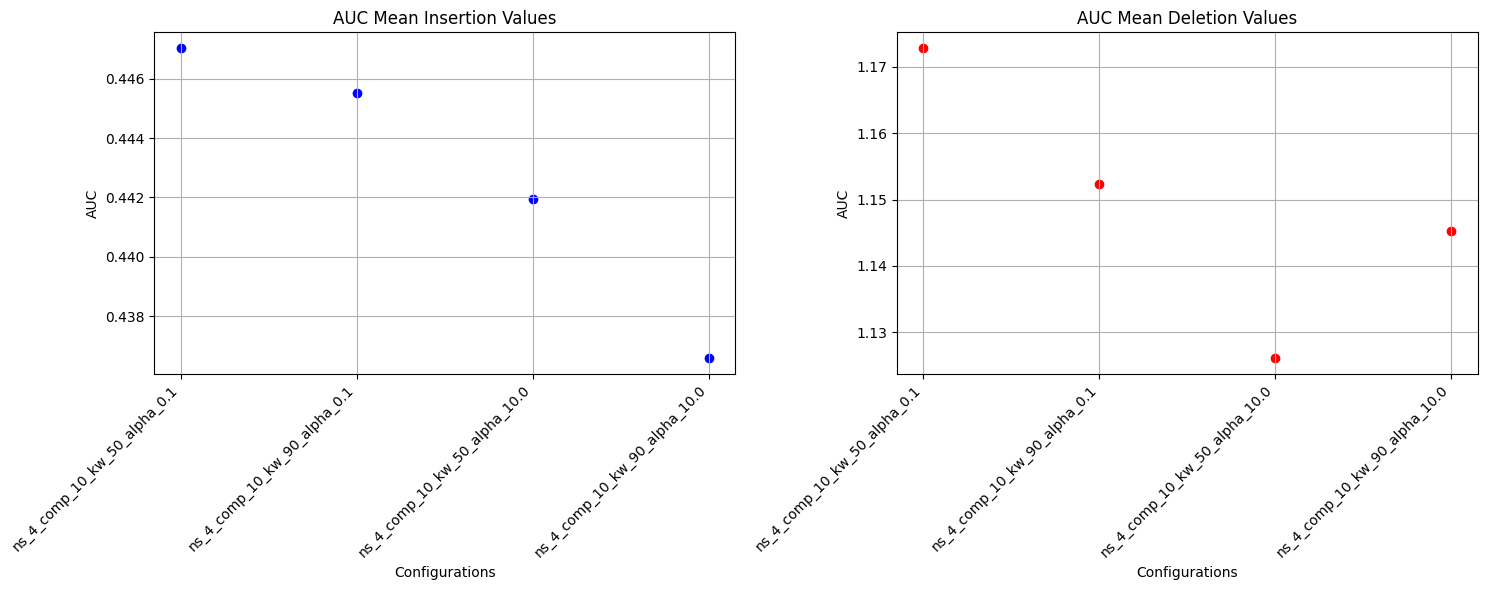

In [36]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 4
comp = 10

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)

plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

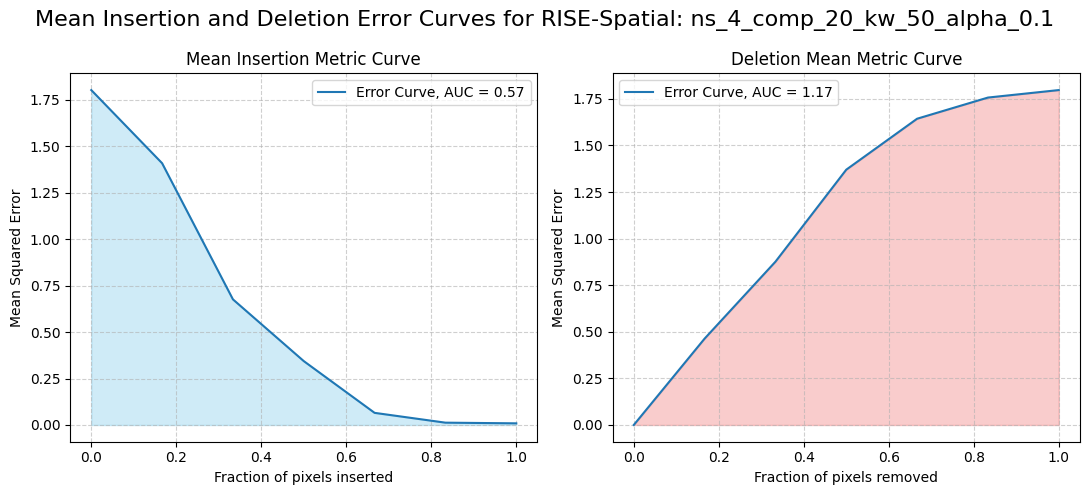

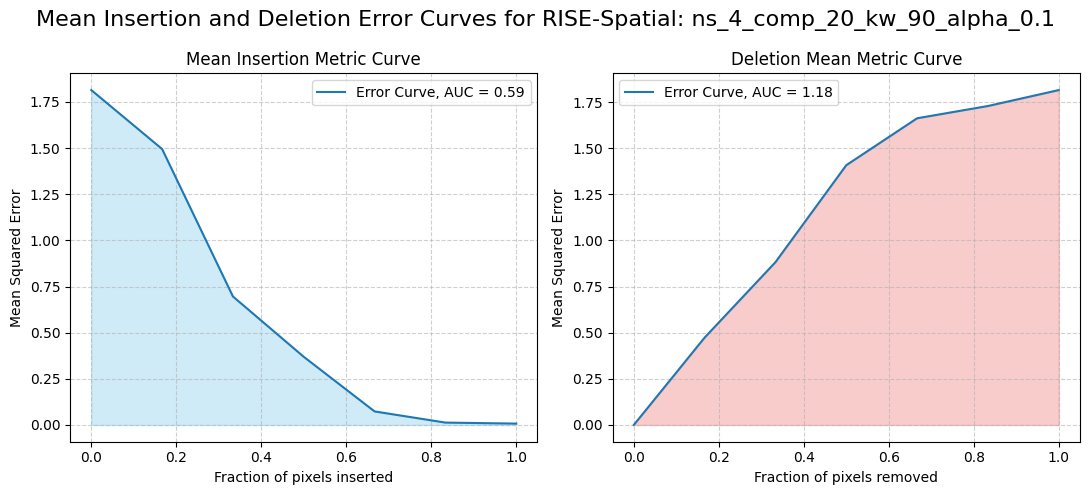

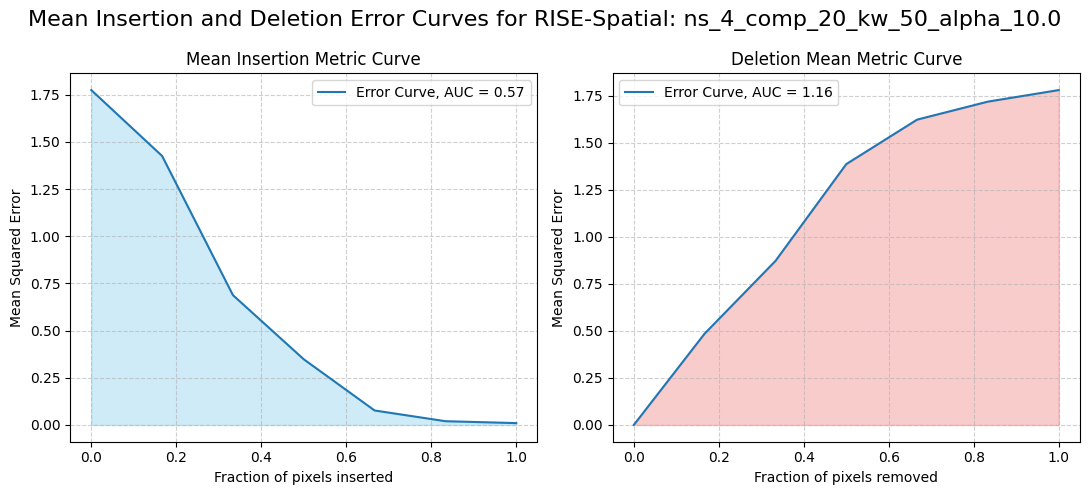

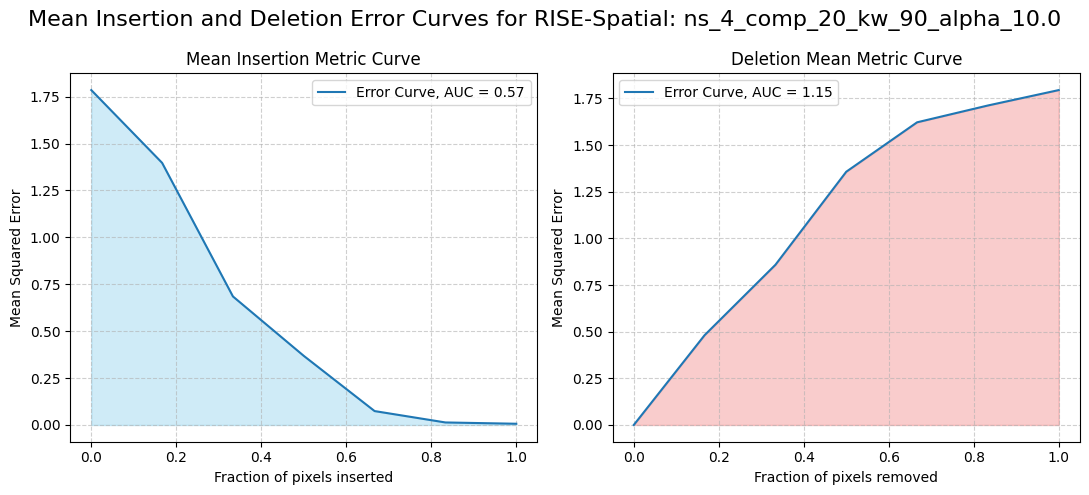

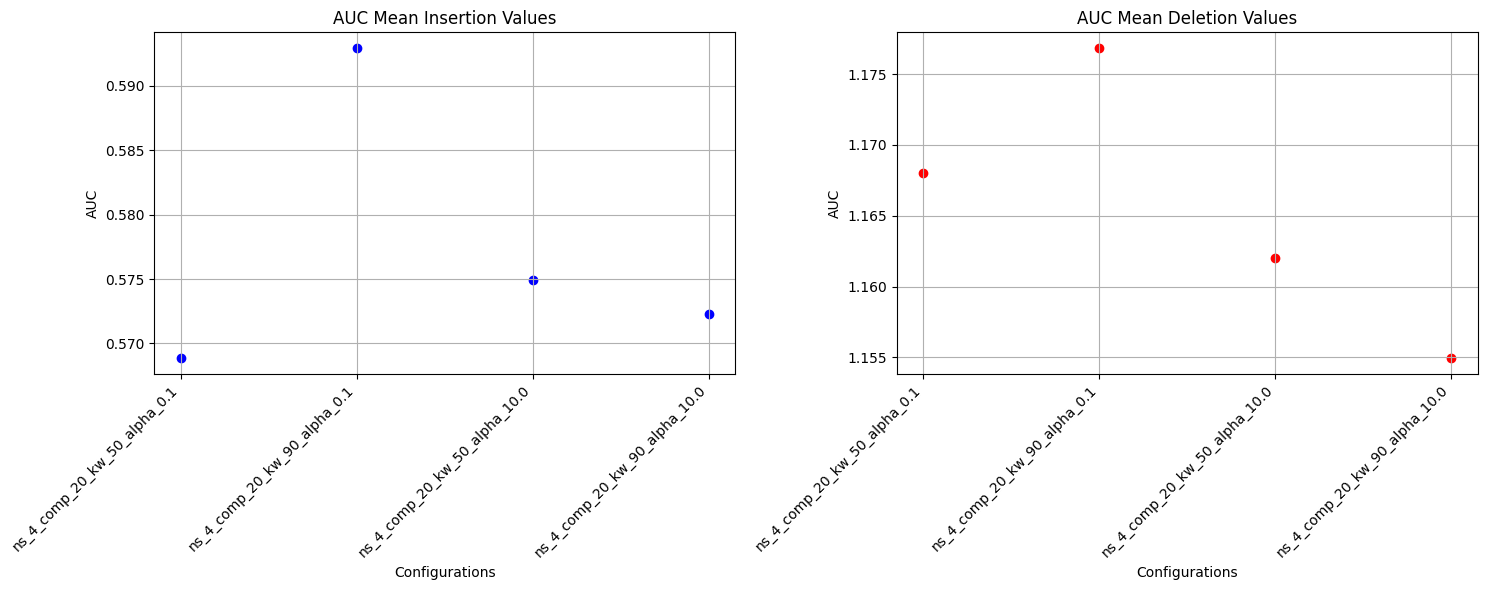

In [37]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 4
comp = 20

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)

plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

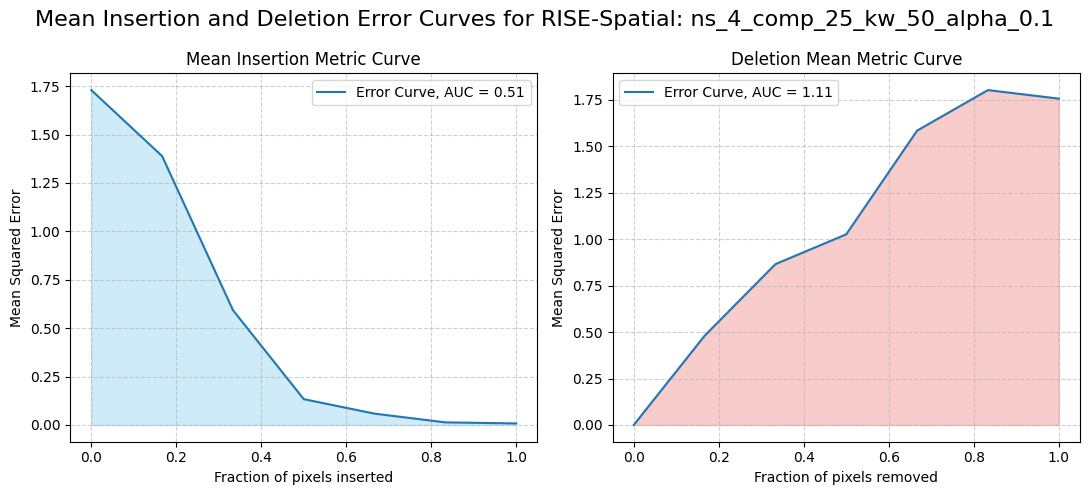

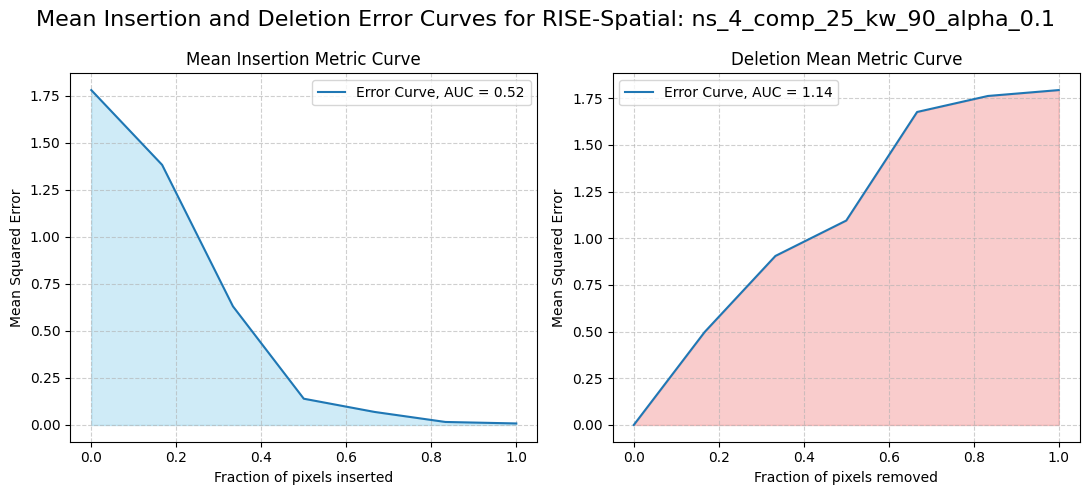

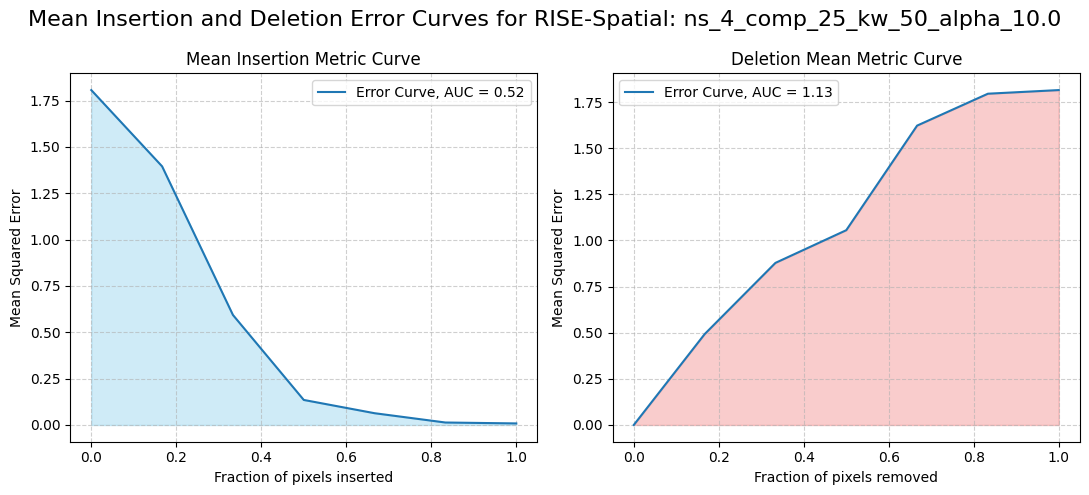

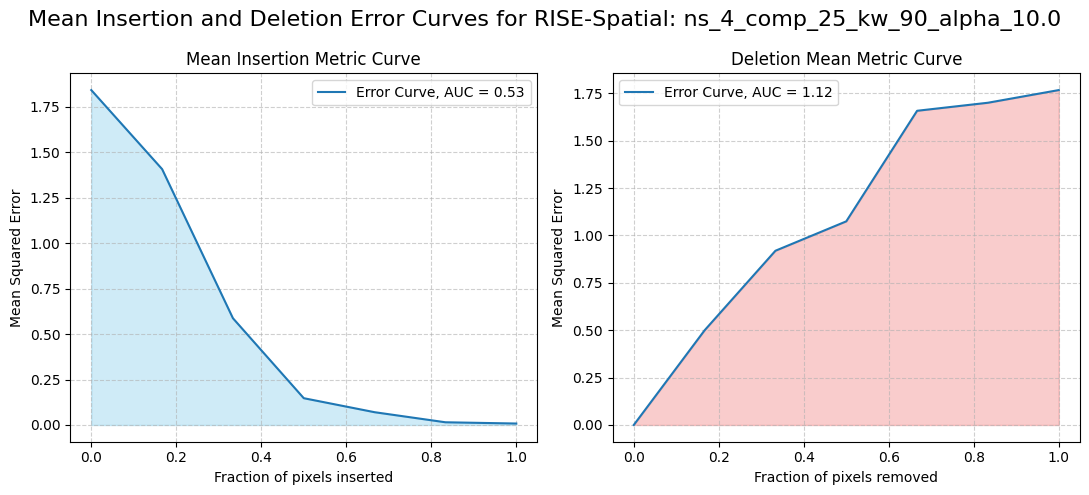

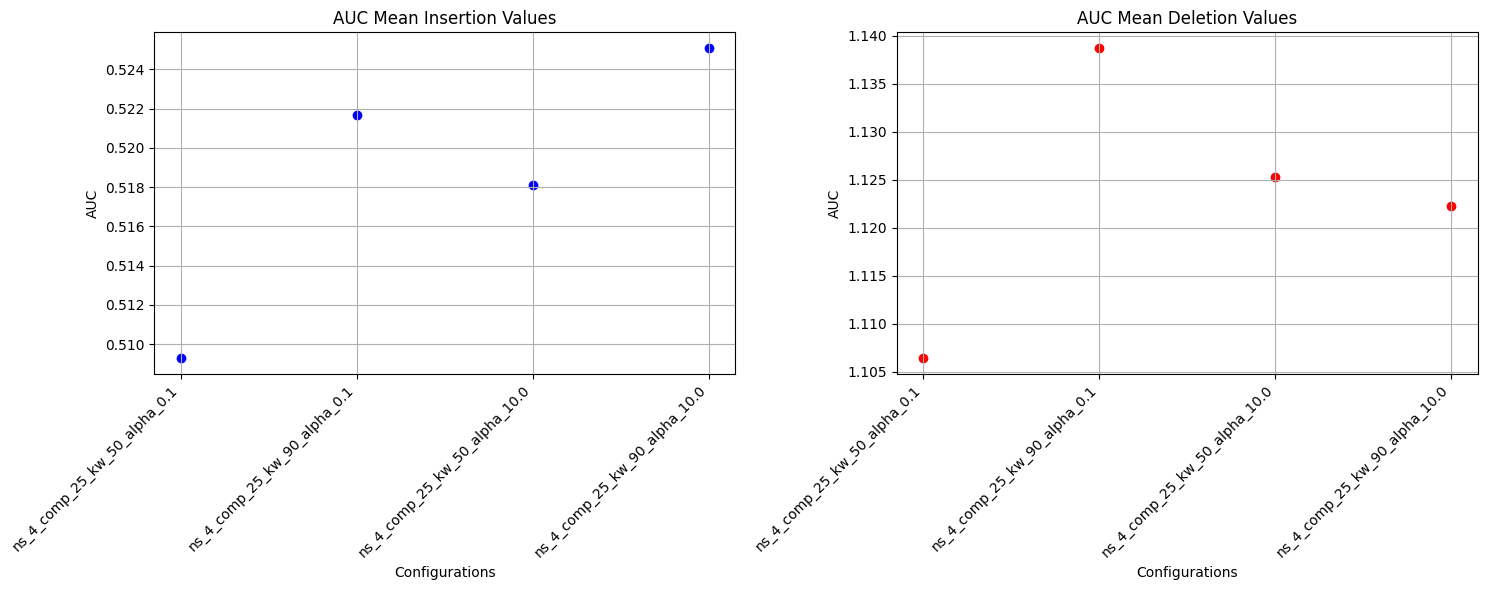

In [38]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 4
comp = 25

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)

plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

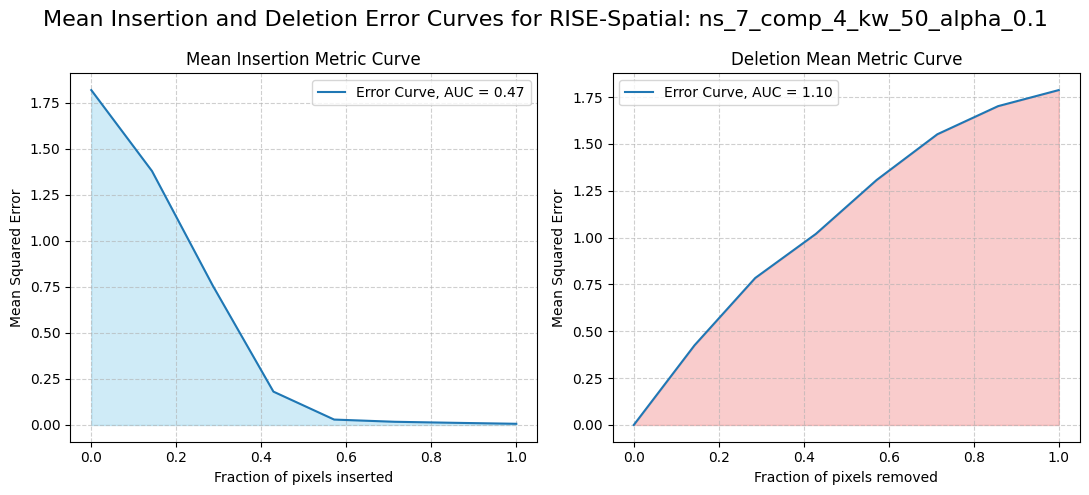

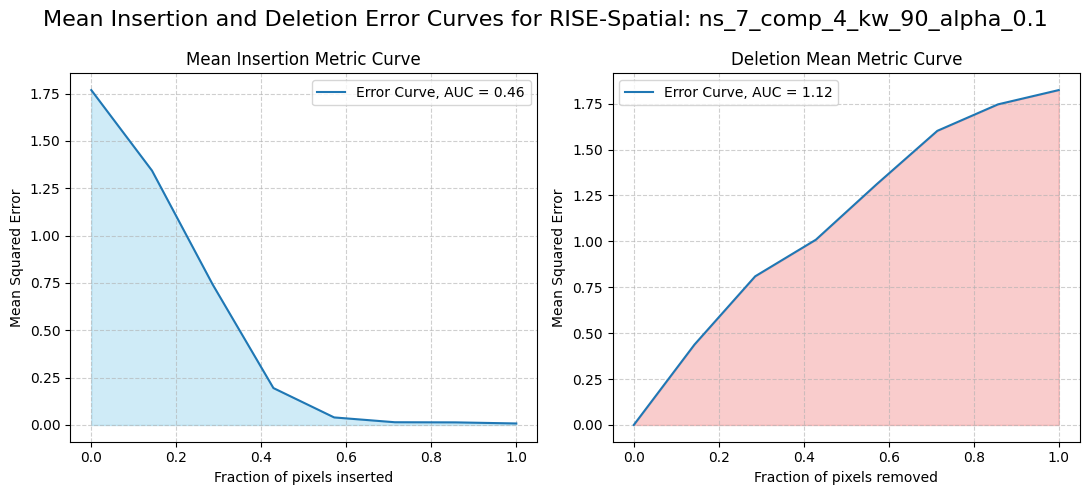

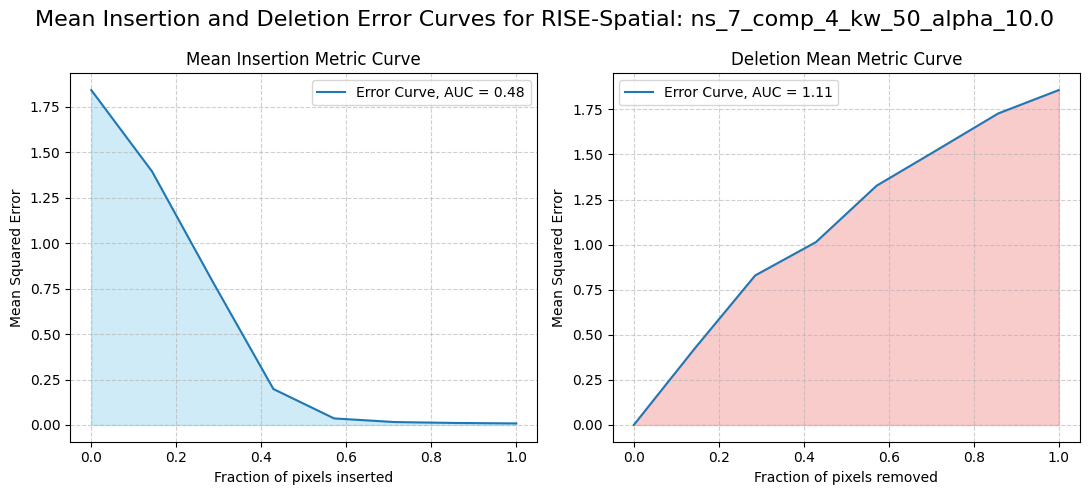

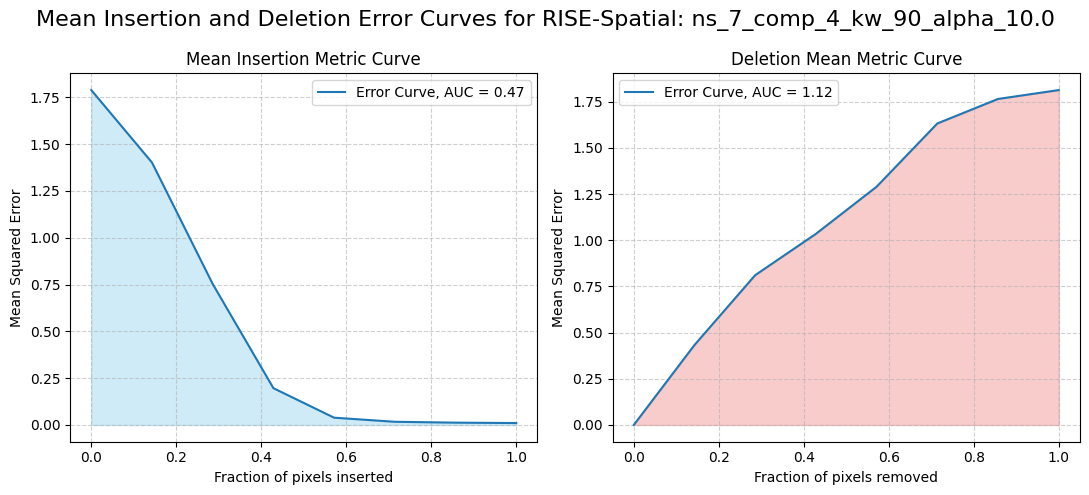

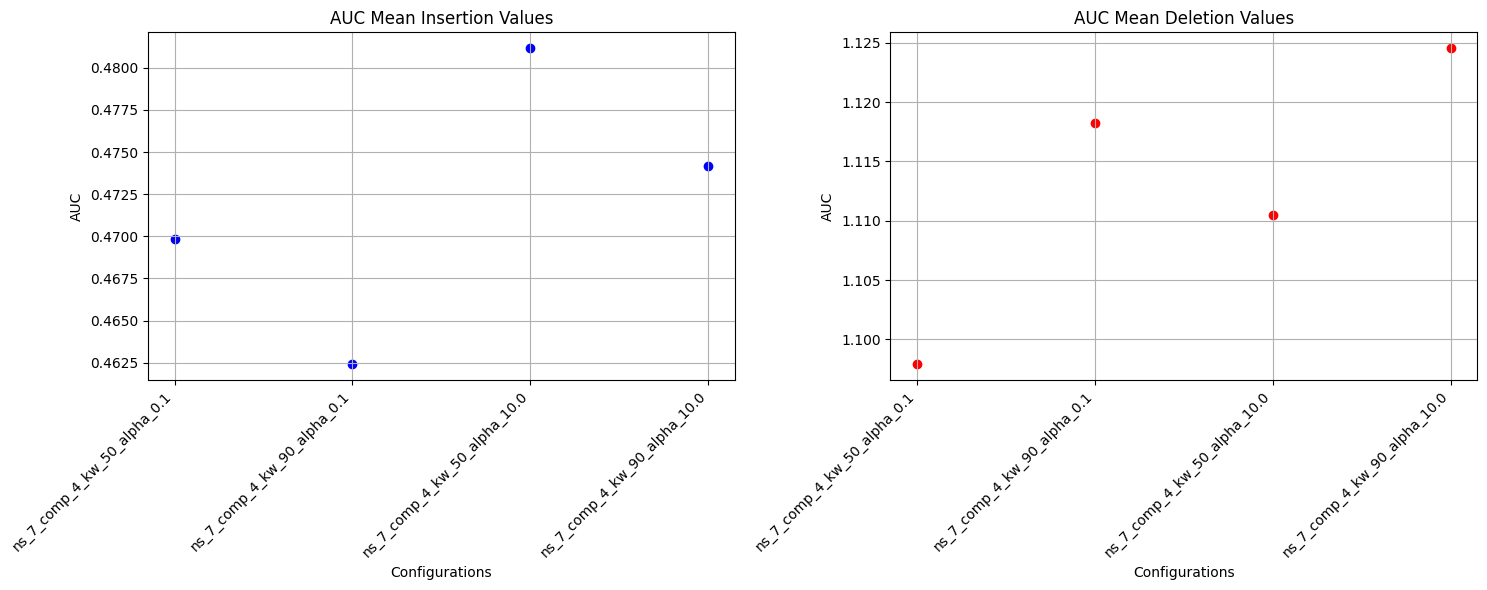

In [39]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 7
comp = 4

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)
plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

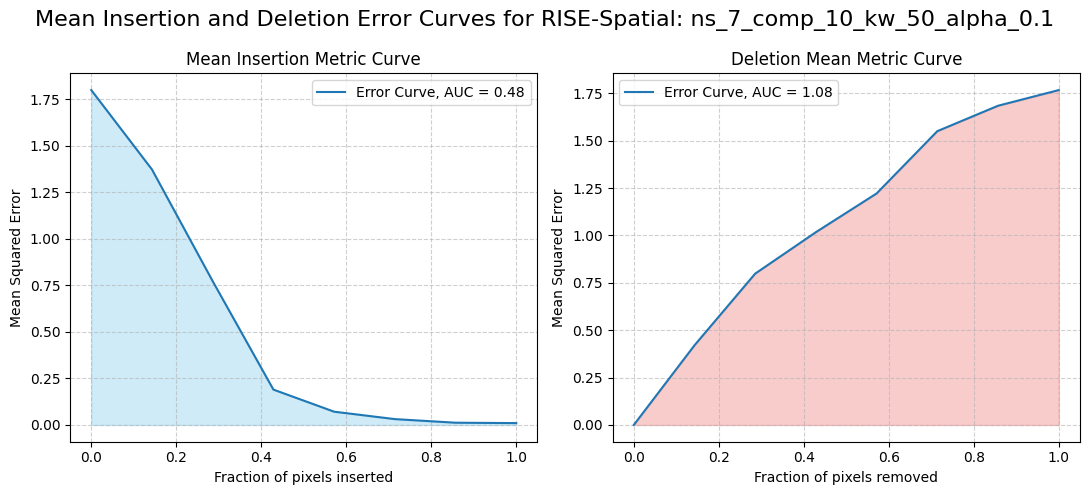

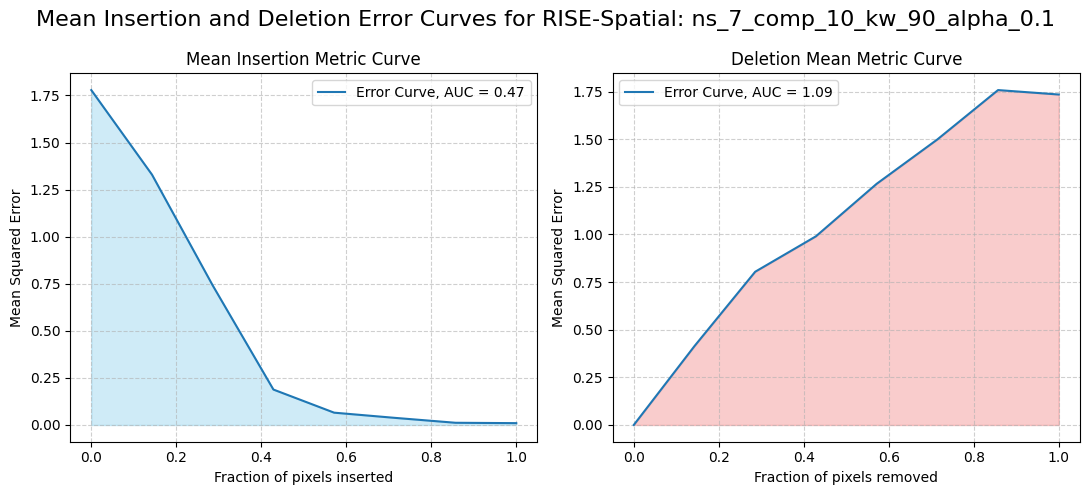

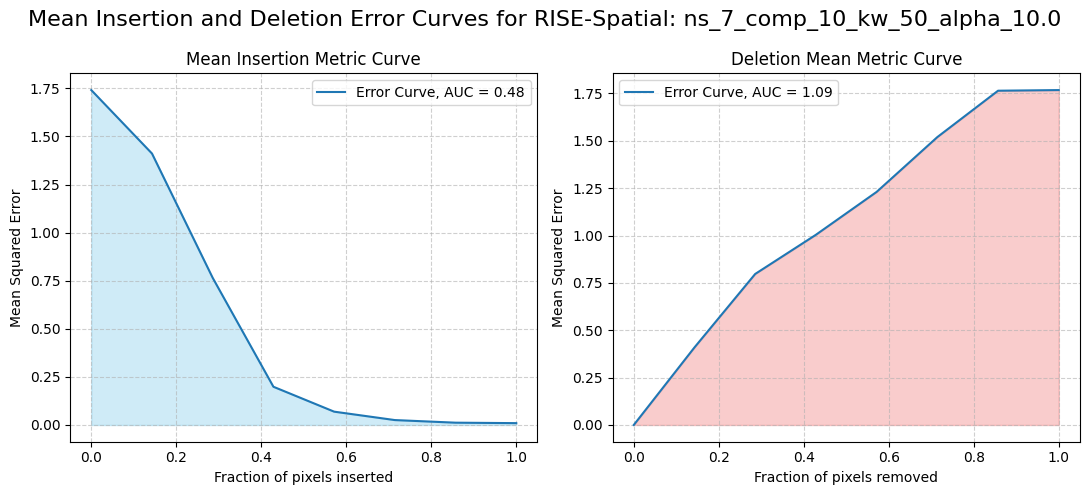

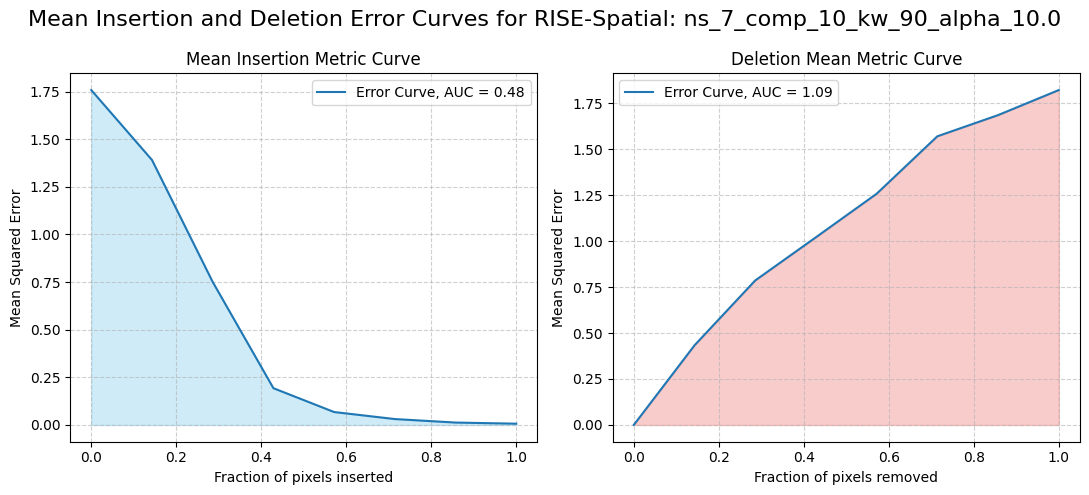

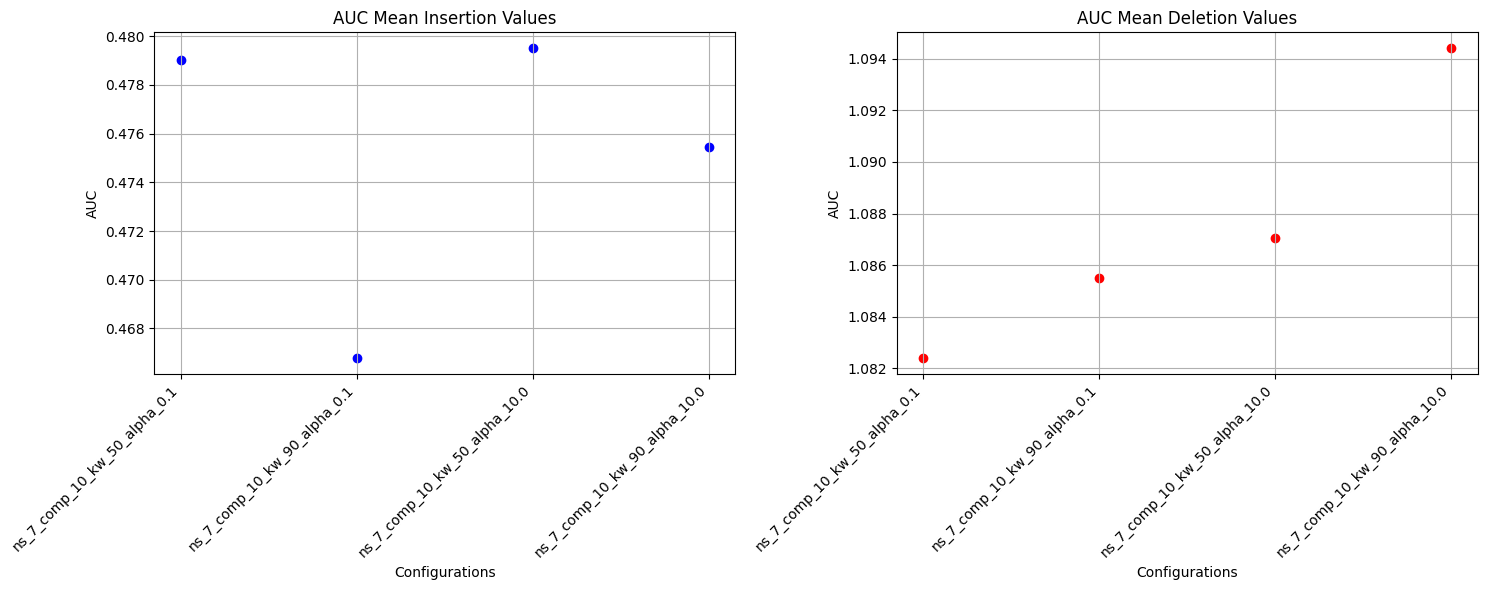

In [40]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 7
comp = 10

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)

plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

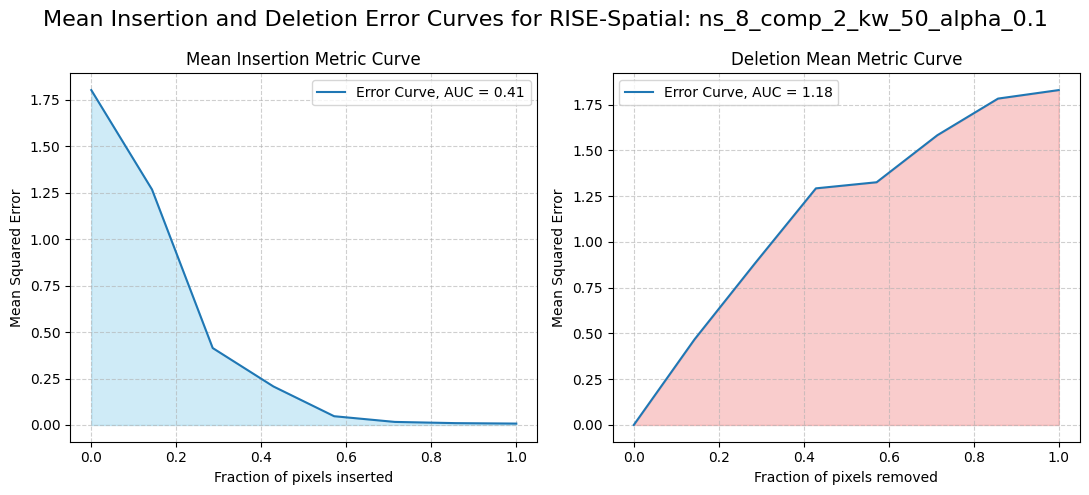

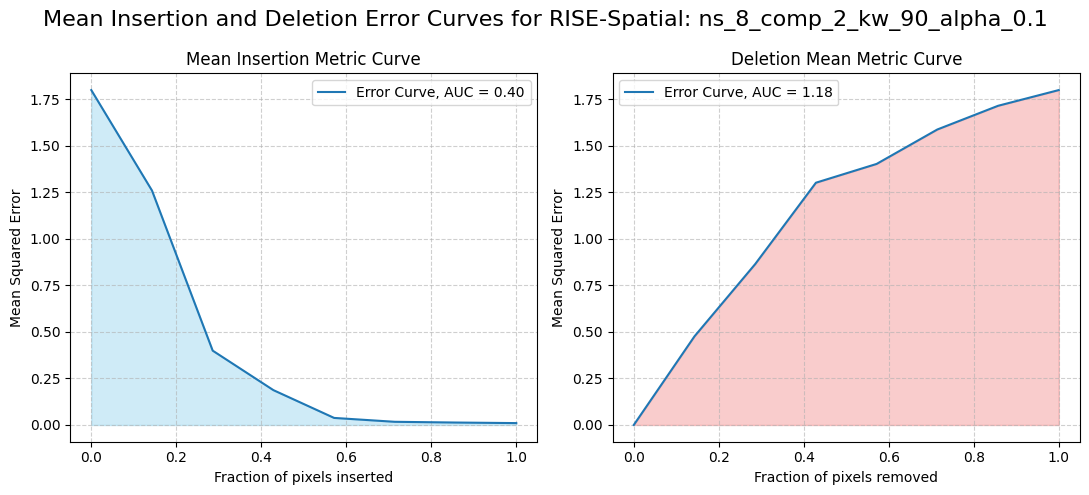

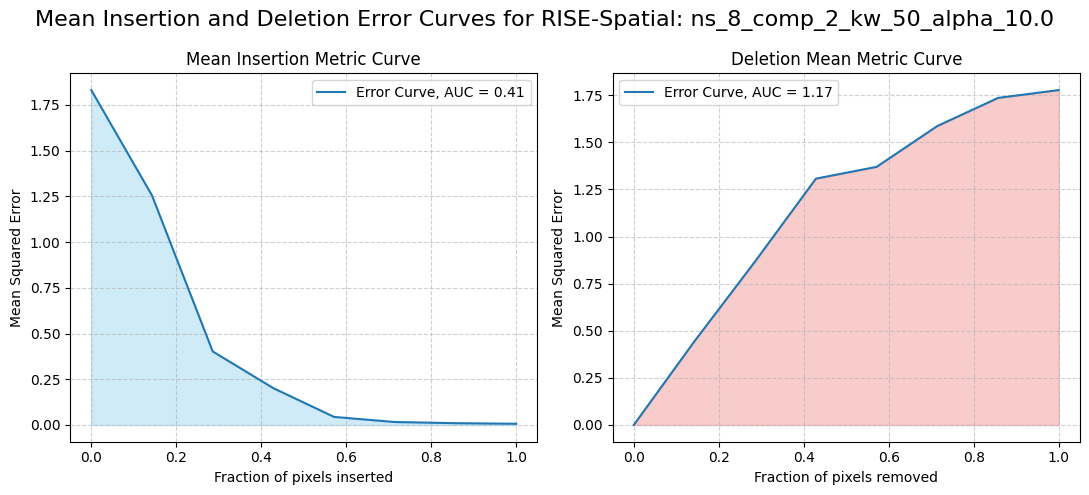

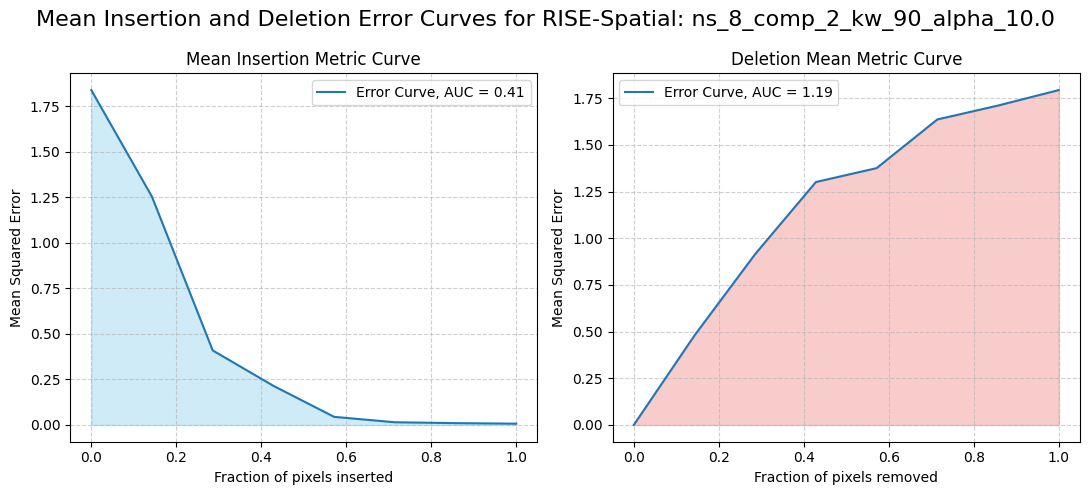

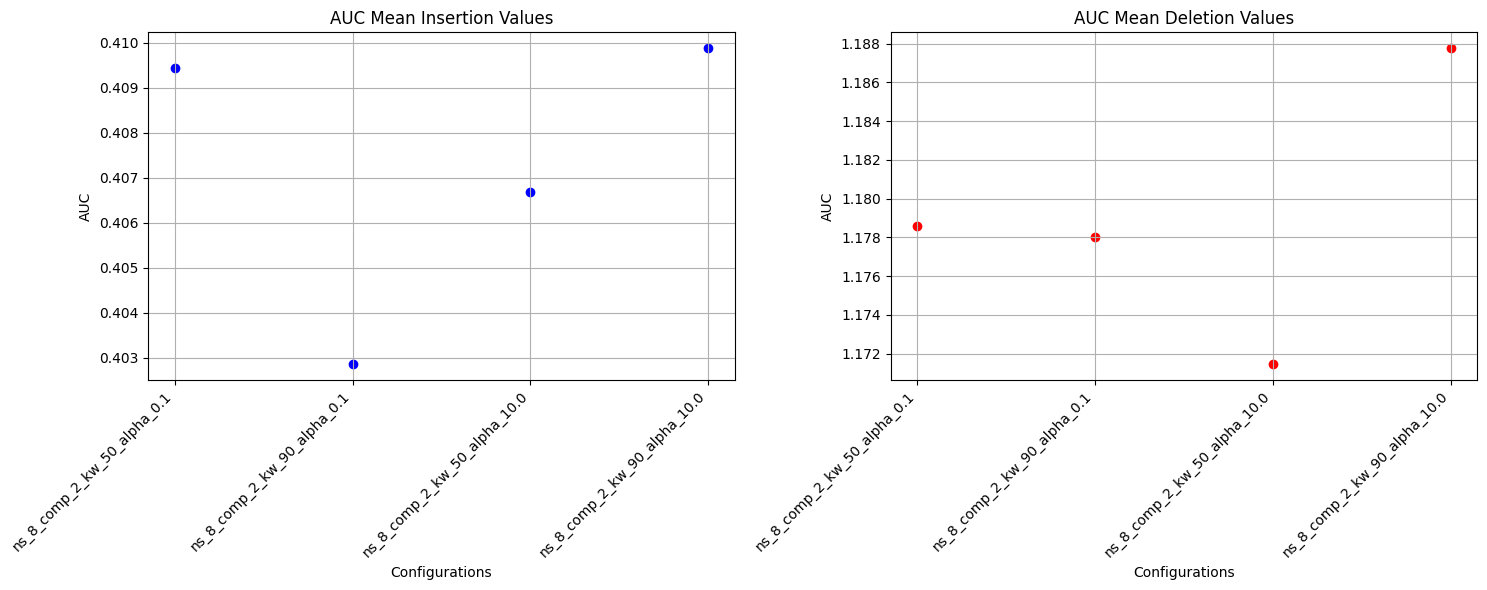

In [41]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 8
comp = 2

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)

plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

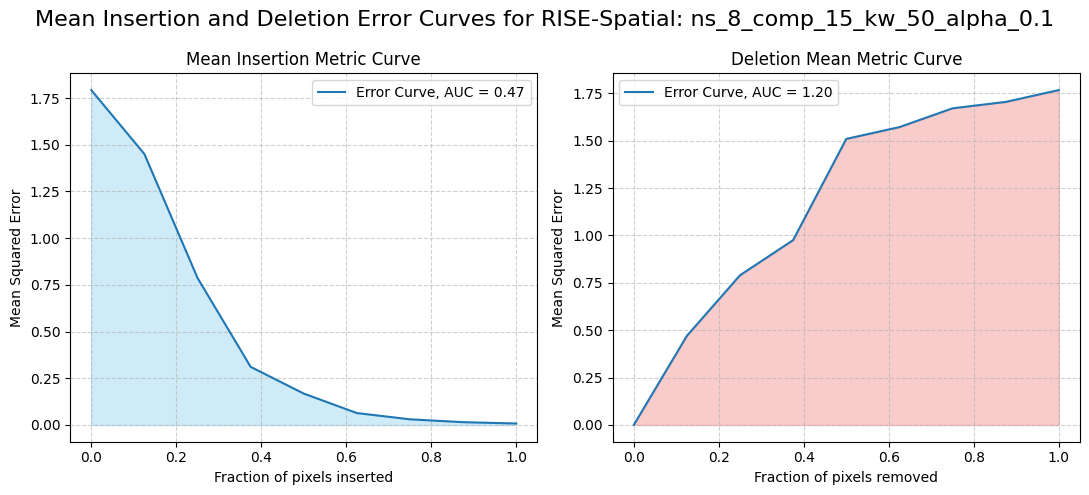

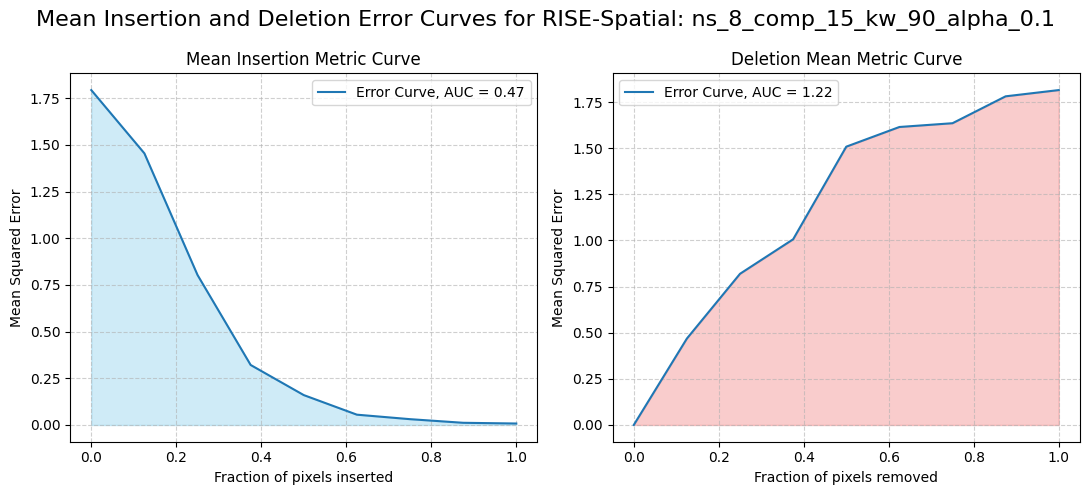

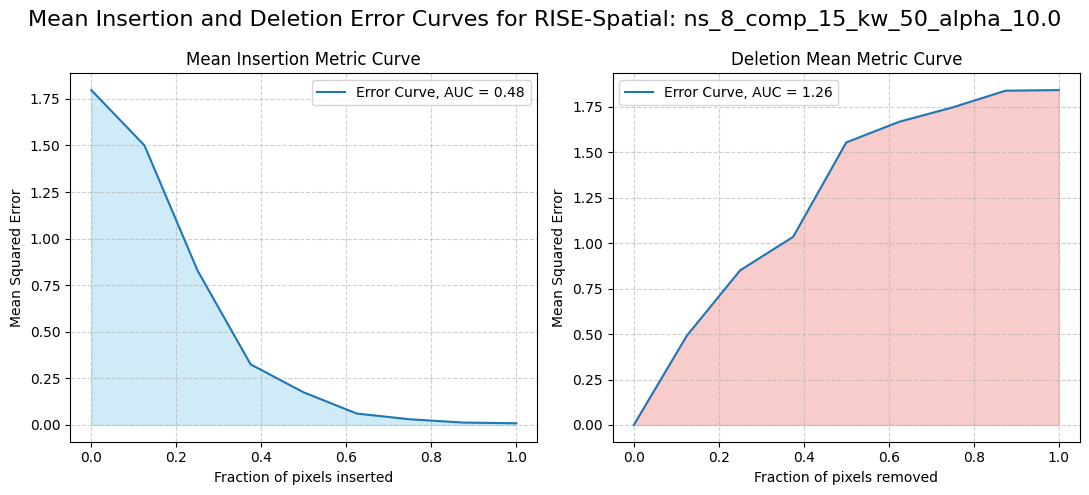

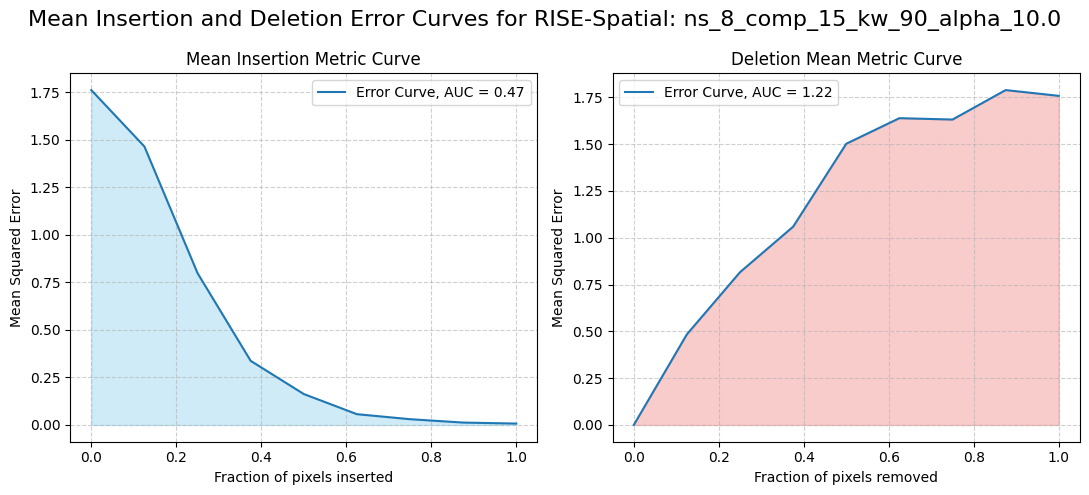

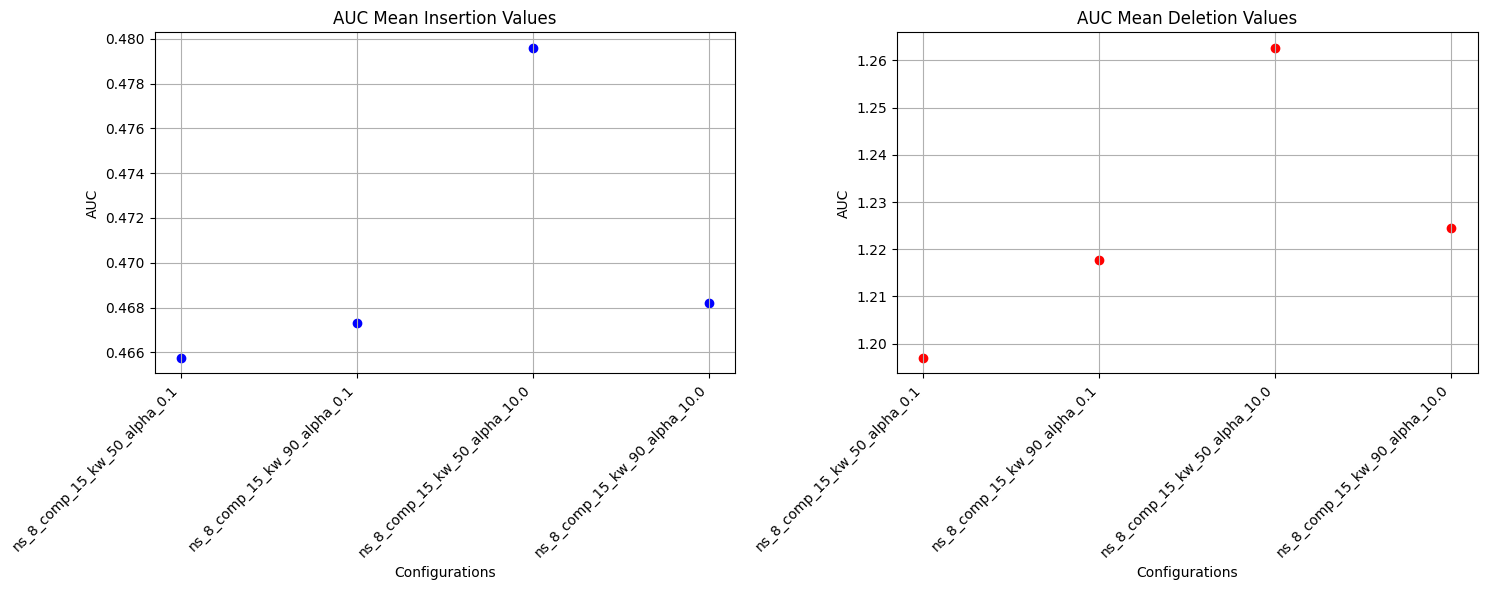

In [42]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 8
comp = 15

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)

plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

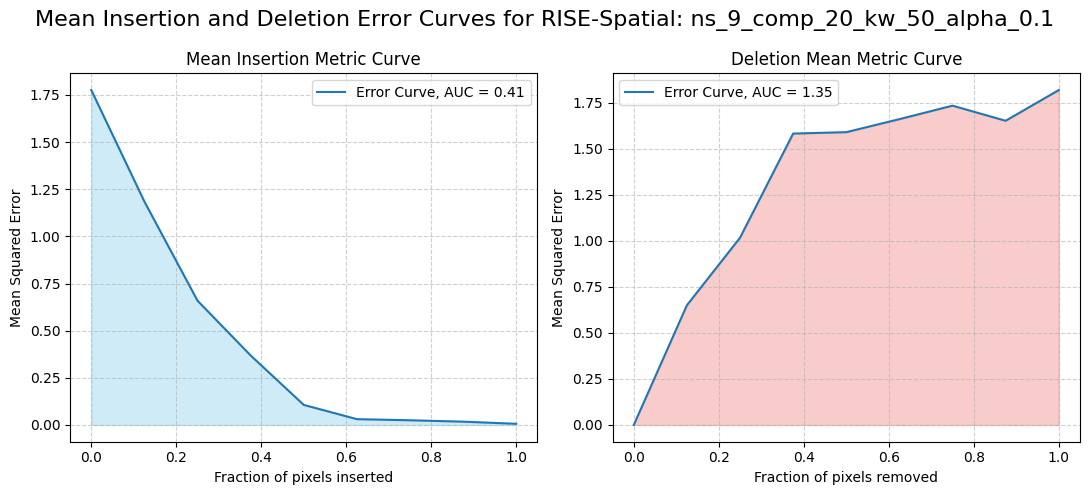

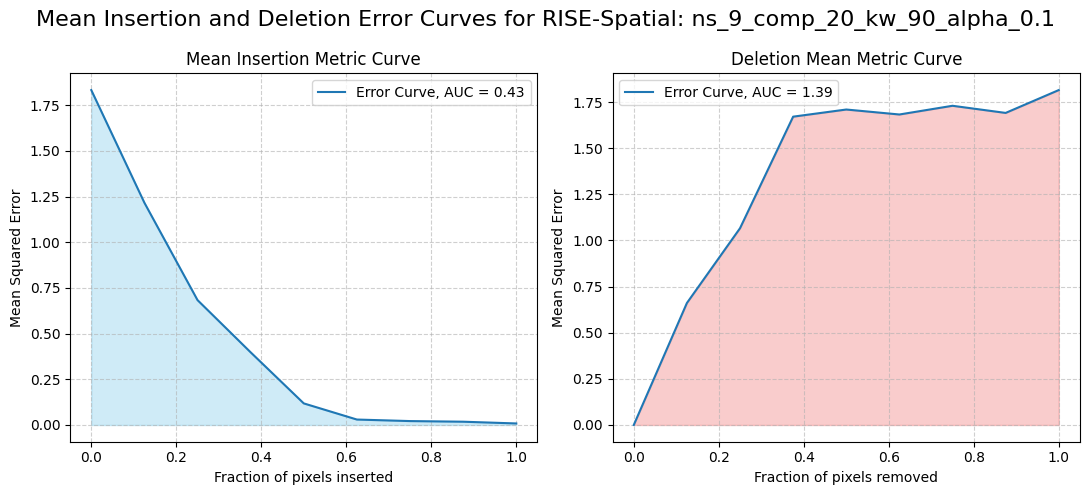

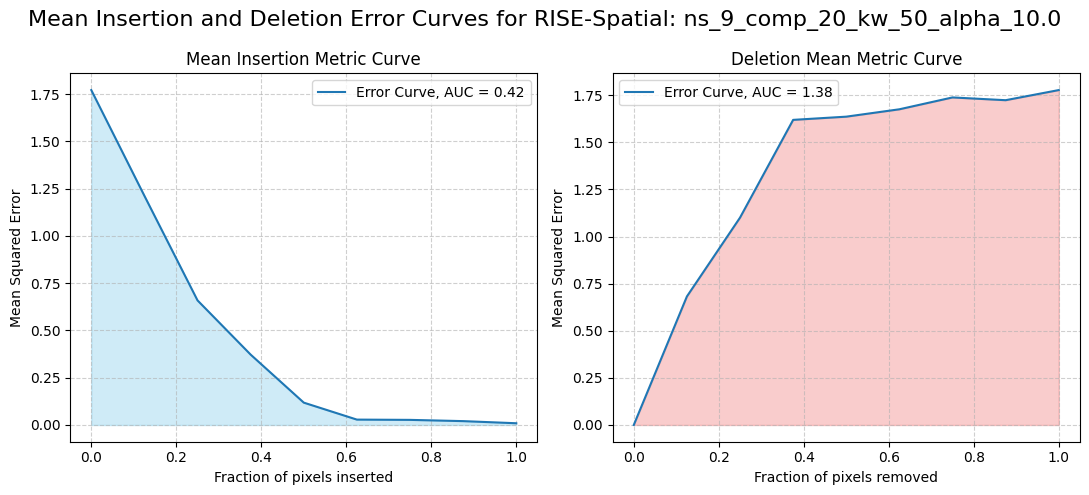

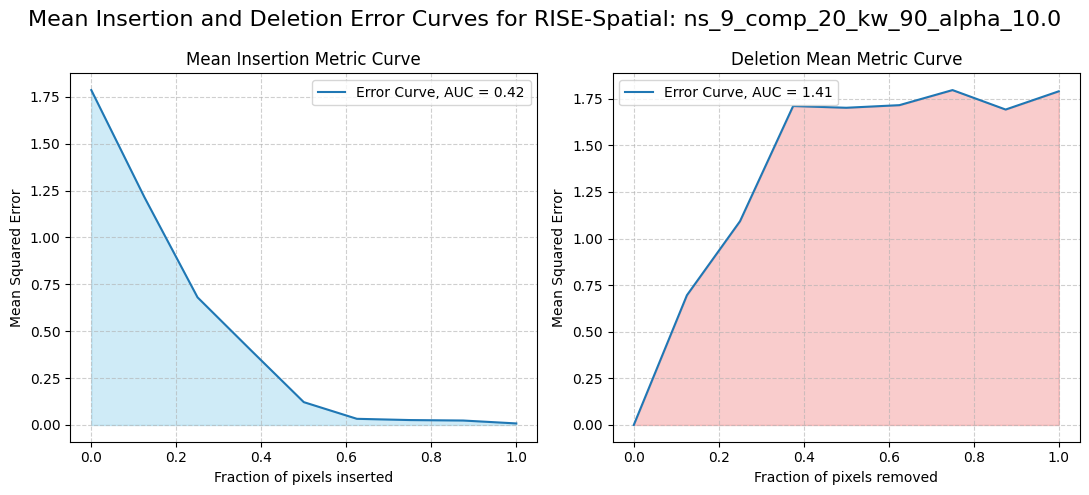

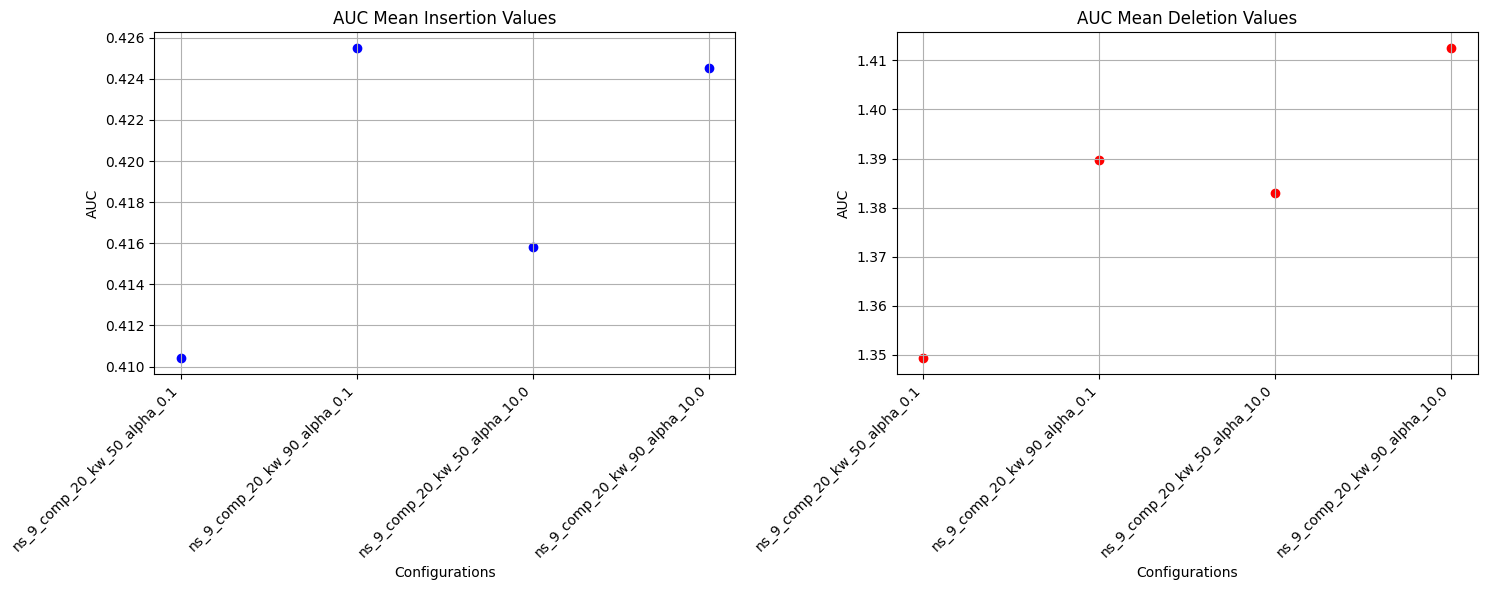

In [43]:
import pickle

base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

alg = "lime"
ns = 9
comp = 20

path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
# Load della lista results
with open(base_path + path_to_load_results, 'rb') as file:
    result_lime = pickle.load(file)

all_param_auc_insertion = []
all_param_auc_deletion  = []

for param_comb in result_lime["lime"]:
    #print(result)
    #result = result_st[0]

    all_errors_insertion = result_lime["lime"][param_comb]["errors_insertion"]
    all_errors_deletion  = result_lime["lime"][param_comb]["errors_deletion"]


    mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for RISE-Spatial: {param_comb}")

    all_param_auc_insertion.append([mean_auc_insertion, param_comb])
    all_param_auc_deletion.append([mean_auc_deletion,param_comb])

total_auc_insertion.append(all_param_auc_insertion)
total_auc_deletion.append(all_param_auc_deletion)

plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)

/scratch_local/ipykernel_1845001/2227001206.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img[nr_lat, nr_lon, 2] = dtm_piemonte_clipped.sel(x=longitude, y=latitude, method='nearest').values
/scratch_local/ipykernel_1845001/2227001206.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img[nr_lat, nr_lon, 2] = dtm_piemonte_clipped.sel(x=longitude, y=latitude, method='nearest').values
/scratch_local/ipykernel_1845001/2227001206.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Depr

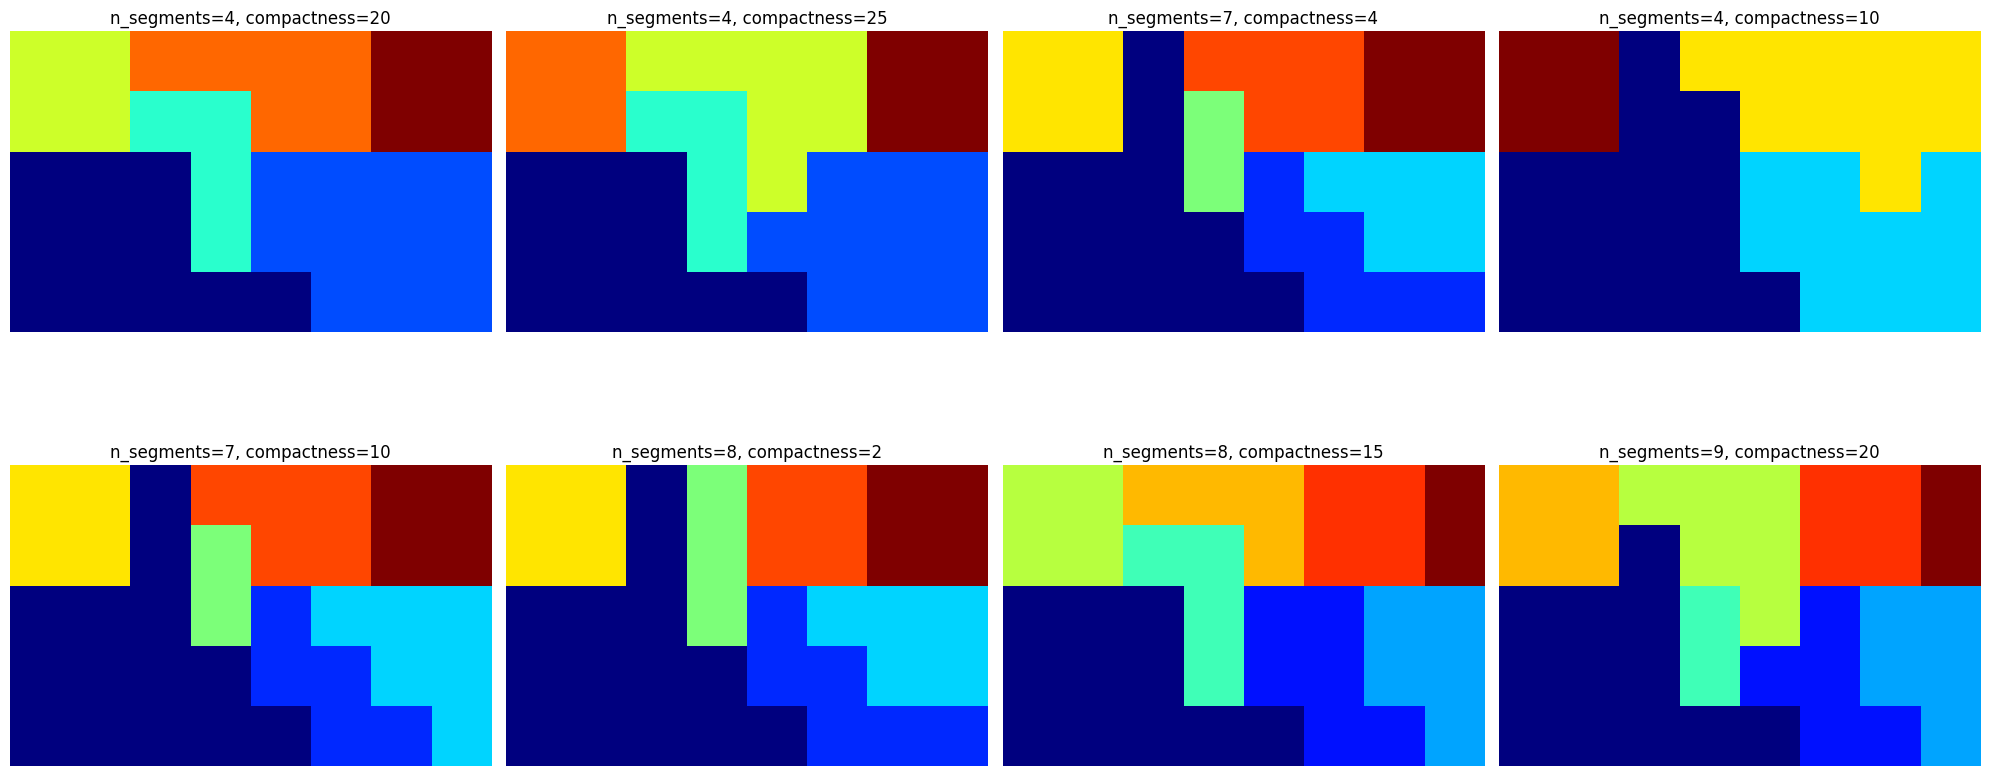

In [52]:
import matplotlib.pyplot as plt

# Parametri SLIC
slic_param = [(4, 20), (4, 25), (7, 4), (4, 10), (7, 10), (8, 2), (8, 15), (9, 20)]

# Imposta la griglia (2 righe, 4 colonne)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Genera i plot
for i, (ns, comp) in enumerate(slic_param):
    _, _, segments = create_spatial_superpixels(shapefile_path, n_segments=ns, compactness=comp)
    axes[i].imshow(segments, origin="lower", cmap='jet')
    axes[i].set_title(f"n_segments={ns}, compactness={comp}")
    axes[i].axis('off')

# Ottimizza il layout
plt.tight_layout()
plt.show()


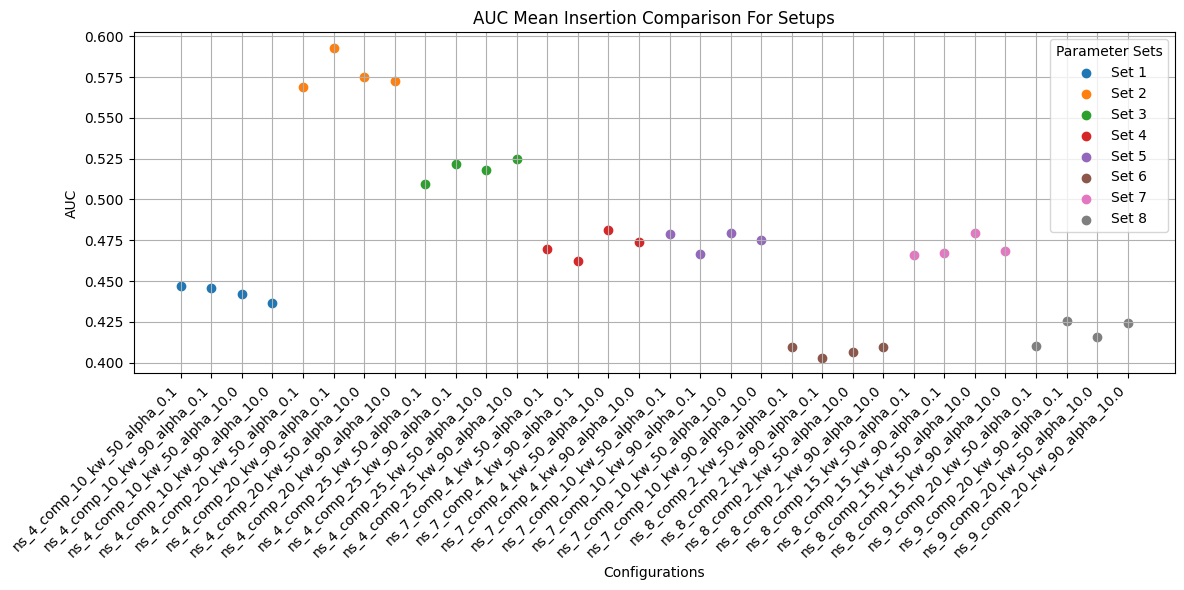

In [46]:
plot_multiple_auc_comparisons(total_auc_insertion, title="AUC Mean Insertion Comparison For Setups")

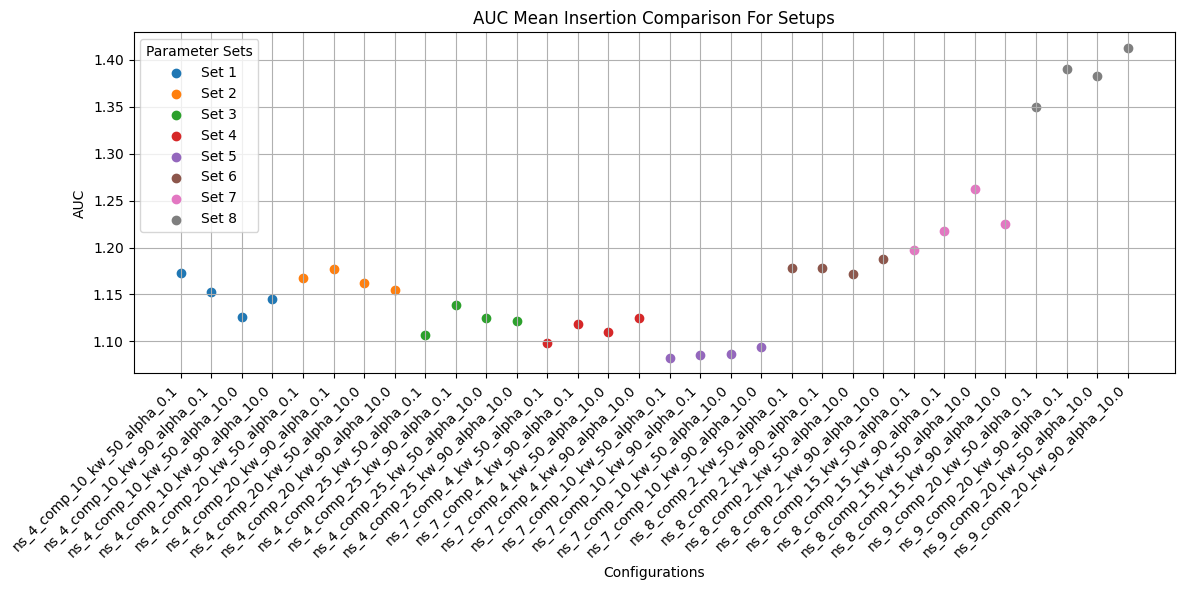

In [47]:
plot_multiple_auc_comparisons(total_auc_deletion, title="AUC Mean Deletion Comparison For Setups")

#### ALL INSTANCES PLOTS

<Axes: >

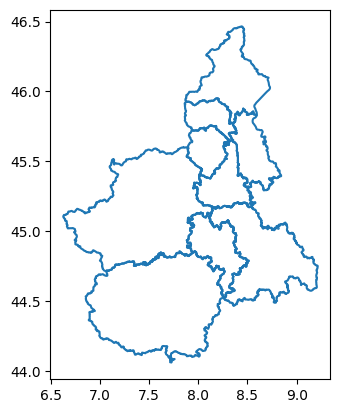

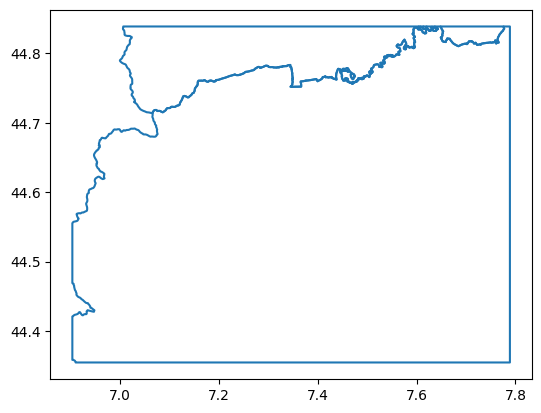

In [2]:
import xarray
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, box, LineString, MultiLineString
import cmasher as cmr

piedmont_shp = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/Ambiti_Amministrativi-Province.shp" 

piedmont_bounds = gpd.read_file(piedmont_shp)
piedmont_bounds = piedmont_bounds.to_crs('epsg:4326')
# remove the small enclaved Cuneo area inside Torino province
piedmont_bounds = piedmont_bounds[:-1]

# extract bound, useful for plots
piemonte_long_min, piemonte_lat_min, piemonte_long_max, piemonte_lat_max = piedmont_bounds.total_bounds

piedmont_bounds.boundary.plot()

# Catchment shapefile
catchment = gpd.read_file("/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/BAC_01_bacialti.shp") # select GRANA-MAIRA	and VARAITA
catchment = catchment.to_crs('epsg:4326')

# Select only the Grana-Maira catchment
catchment_GM = catchment.loc[catchment.NOME == "GRANA-MAIRA"]
catchment_GM = catchment_GM.reset_index(drop = True)

# Retrieve the borders of the catchment from the shapefile
xmin_clip, ymin_clip, xmax_clip, ymax_clip = catchment_GM.total_bounds
# Extend the borders to include more pixel on the borders

increase = 0.05 # Degrees
#ymin_clip -= increase # not needed
xmin_clip += increase # "+" for subset for pixel included in the mask
xmax_clip += increase
#ymax_clip += increase # not needed

# Define a box around the Region of Interest (ROI)
ROI_box = box(xmin_clip, ymin_clip, xmax_clip , ymax_clip)

ROI_shp = piedmont_bounds.clip(ROI_box)
ROI_shp.boundary.plot()

In [3]:
meteo_ds = xarray.open_dataset("/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/meteo_data_ARPA_GM_clipped.nc") # reading ERA5 file
# ARPA Water Table sensors in Cuneo and Torino Provinces
arpa_wt_sensors = gpd.read_file("/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/shapefile_raster/CN_TO_observed_d_t_c_stations.shp")
arpa_wt_sensors = arpa_wt_sensors.to_crs('epsg:4326')
arpa_wt_sensors = arpa_wt_sensors.loc[arpa_wt_sensors.Munic.isin(["Vottignasco"])]

In [4]:
import numpy as np
import xarray
import matplotlib.pyplot as plt
import cmasher as cmr

def plot_saliency_map_matteo(saliency_map, current_instance, data_target, meteo_ds, 
                            catchment, piedmont_bounds, arpa_wt_sensors,
                            cmap='seismic', mode="standard",
                            alpha=0.95, title_prefix='RISE Saliency',
                            save=False, save_path=""):
    """
    Plotta la mappa di salienza con i punti dei sensori WTD.
    
    Parametri:
    - saliency_map: array 2D con i valori di salienza (shape: [lat, lon])
    - current_instance: indice corrente per il titolo
    - data_target: data associata all'istanza
    - meteo_ds: dataset con le coordinate lat e lon
    - catchment: confini del bacino da plottare
    - piedmont_bounds: confini del Piemonte da plottare
    - arpa_wt_sensors: geodataframe con le coordinate dei sensori WTD
    - cmap: colormap da usare (default: 'seismic')
    - mode: "standard" per la colormap normale, "reversed" per invertirla
    - alpha: trasparenza della mappa (default: 0.95)
    - title_prefix: prefisso del titolo (default: 'Spatial saliency')
    - save: se True, salva il grafico invece di mostrarlo
    - save_path: percorso dove salvare il grafico
    """
    
    # Converti in DataArray per compatibilità con xarray
    xarray_saliency = xarray.DataArray(
        data=saliency_map,
        dims=["y", "x"],
        coords=dict(y=("y", meteo_ds.coords["lat"].values),
                    x=("x", meteo_ds.coords["lon"].values))
    )
    
    vmin = np.min(xarray_saliency)
    vmax = np.max(xarray_saliency)

    # Seleziona la colormap (invertita o normale)
    selected_cmap = cmr.get_sub_cmap(cmap, 0.5, 1)
    if mode == "reversed":
        selected_cmap = selected_cmap.reversed()

    # Setup del plot
    fig, ax = plt.subplots()
    catchment.boundary.plot(ax=ax, color="Blue", linewidth=0.1, alpha=1)
    piedmont_bounds.boundary.plot(ax=ax, color='Black', linewidth=0.5, alpha=0.6)
    
    # Plotta la mappa di salienza
    xarray_saliency.plot(ax=ax, cmap=selected_cmap, vmin=vmin, vmax=vmax, alpha=alpha)

    # Plotta i sensori WTD come puntini gialli
    arpa_wt_sensors.plot(ax=ax, color='tab:blue', marker='o', markersize=50, label='WTD Sensor', alpha=1)

    # # Annotazioni per i sensori WTD
    # for x, y in zip(arpa_wt_sensors.geometry.x.values, arpa_wt_sensors.geometry.y.values):
    #     ax.annotate("WTD Sensor",
    #                 xy=(x, y), xycoords='data',
    #                 xytext=(x - 0.1, y + 0.15), textcoords='data',
    #                 size=12, va="center", ha="center",
    #                 bbox=dict(fc="w"),
    #                 arrowprops=dict(arrowstyle="-|>",
    #                                 connectionstyle="arc3,rad=-0.2",
    #                                 fc="w"))
    
    # Titolo del grafico
    fig.suptitle(f'{title_prefix} #{current_instance} Date Target: [{data_target[0]}]', fontsize=12)
    
    # Salvataggio o visualizzazione
    if save:
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.savefig(save_path, dpi=400)
        plt.close(fig)
    else:
        plt.show()

In [5]:
import pickle 
import numpy as np

path_to_load_results = f"/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/01_marco_spatial_lime_shap_20250308141042/lime_shap_spatial_results_setup_ns_8_comp_2.pkl"
    # Load della lista results
with open(path_to_load_results, 'rb') as file:
    results = pickle.load(file)

In [ ]:
import pickle 
import numpy as np

path_to_load_results = f"/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/01_marco_spatial_rise_original_stability20250311154927/rise_spatial_original_stability_all_seeds.pkl"
    # Load della lista results
with open(path_to_load_results, 'rb') as file:
    results = pickle.load(file)


for nr_instance in range(79,len(vottignasco_test_image)):

    data_target = vottignasco_test_dates[nr_instance].astype('datetime64[D]')

    for index_i in range(2,5):
        output_path_mean = f"/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/scripts/notebooks/results/results_spatial_stability_mean/#{nr_instance}_S{index_i}_mean"
        output_path_std  = f"/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/scripts/notebooks/results/results_spatial_stability_std/#{nr_instance}_S{index_i}_std"

        all_nr_instances_instances_s_i = np.zeros((10,5,8))
        
        for nr_result,result in enumerate(results):

            all_nr_instances_instances_s_i[nr_result] = result["saliency_maps"][nr_instance,(index_i-1),:]
        
        s_i_mean_all_seed_instance_nr_instance = np.mean(all_nr_instances_instances_s_i, axis=0)
        s_i_std_all_seed_instance_nr_instance  = np.std(all_nr_instances_instances_s_i, axis=0)

        if index_i == 1 or index_i == 3:
            mode_mean = "standard"
        else:
            mode_mean = "reversed"

        plot_saliency_map_matteo(s_i_mean_all_seed_instance_nr_instance, nr_instance, data_target, meteo_ds, 
                         catchment, piedmont_bounds, arpa_wt_sensors, mode=mode_mean,title_prefix=f"RISE Saliency Mean,",
                         save=True, save_path=output_path_mean)
        plot_saliency_map_matteo(s_i_std_all_seed_instance_nr_instance, nr_instance, data_target, meteo_ds, 
                         catchment, piedmont_bounds, arpa_wt_sensors, mode="reversed",title_prefix=f"RISE Saliency Std,",
                         save=True, save_path=output_path_std)
        
    print(f"END {nr_instance}")

### *Shap*

In [ ]:
import pickle

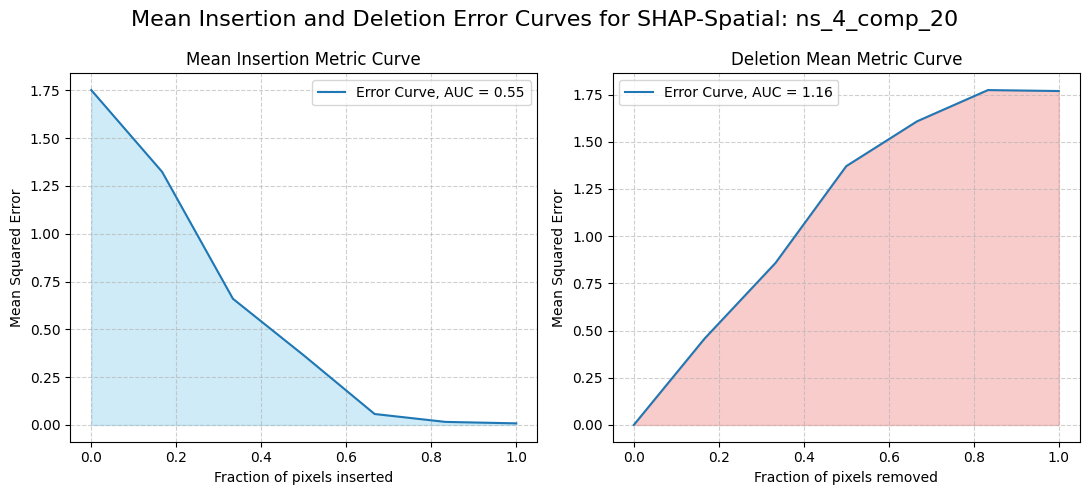

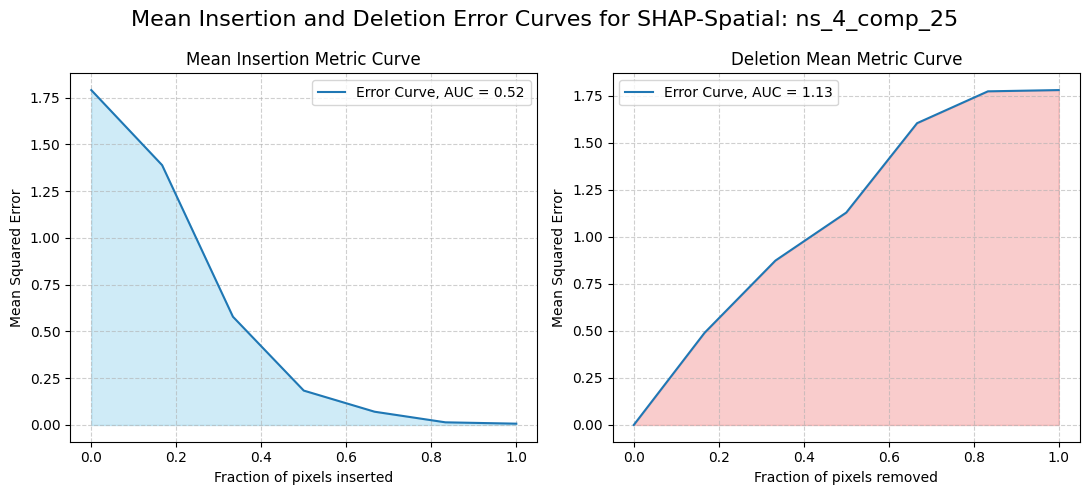

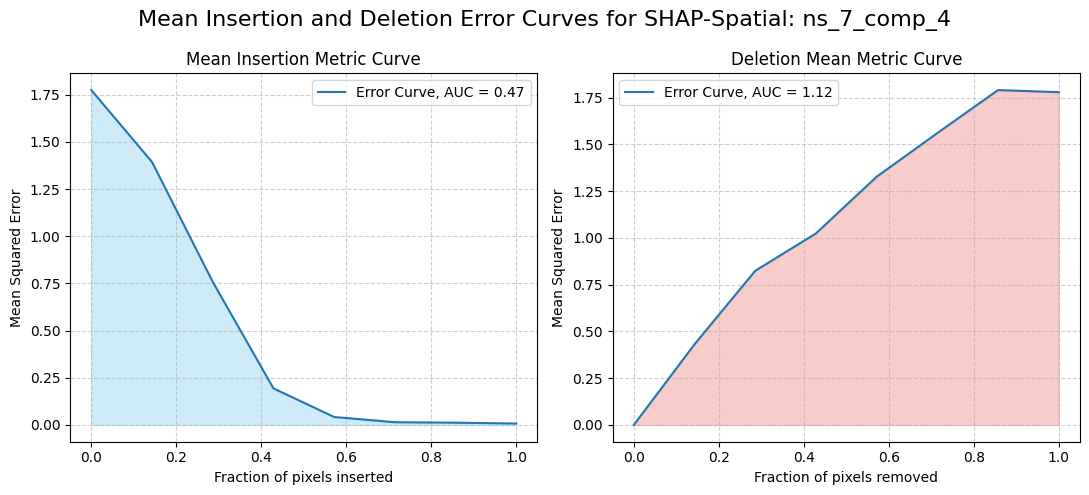

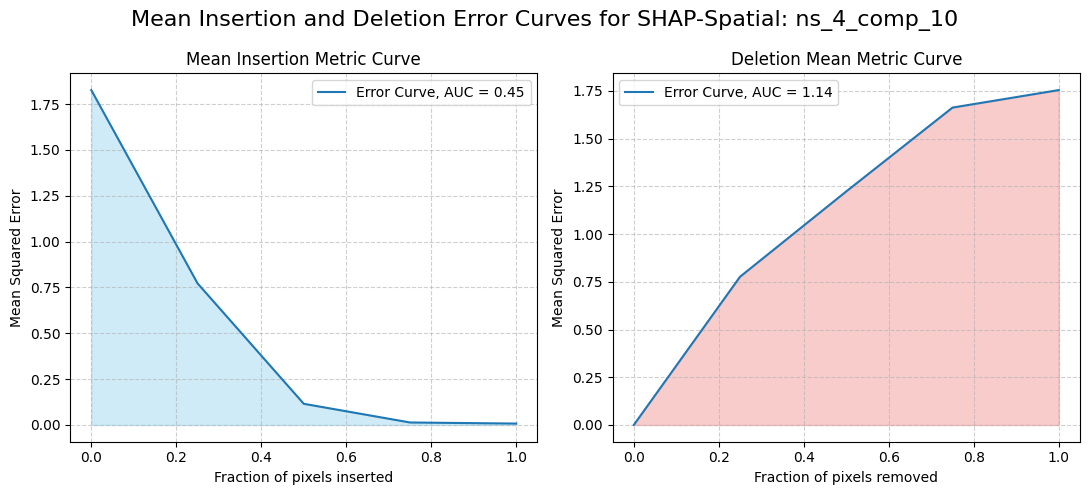

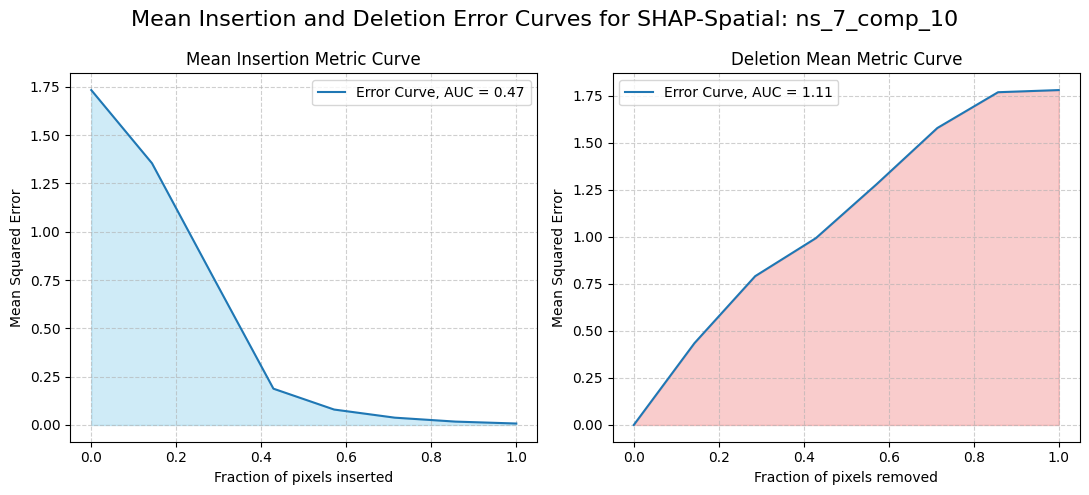

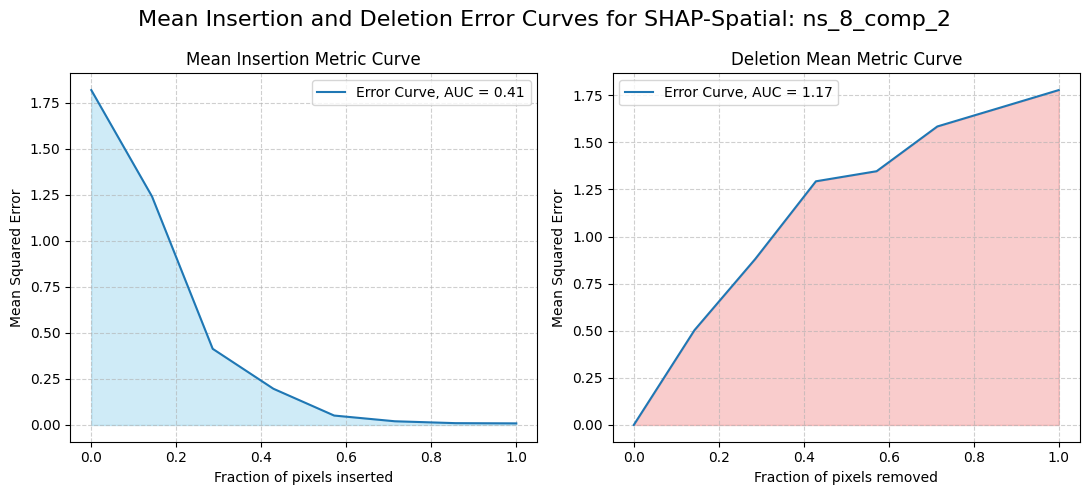

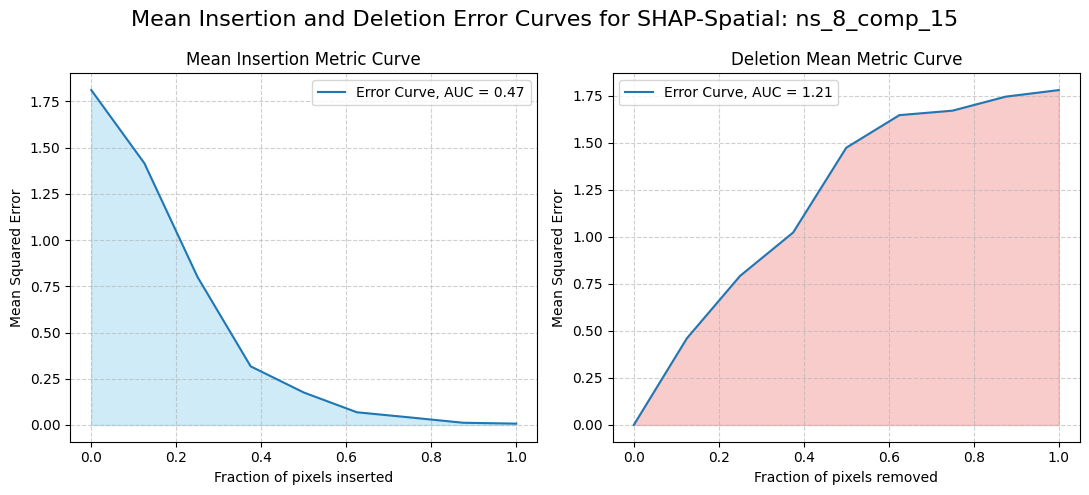

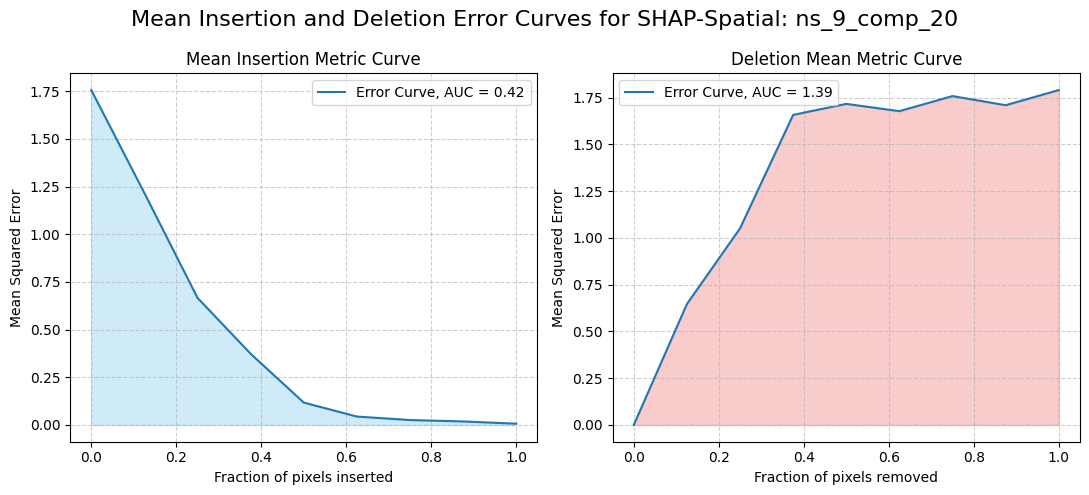

In [57]:
base_path = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/spatial/results/lime_shap_multiplicative_norm_zero/"
#path_to_load_results = os.path.join(work_path, "Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_inv_sigmoide.pkl")

total_auc_insertion = []
total_auc_deletion  = []

alg = "shap"
# Parametri SLIC
slic_param = [(4, 20), (4, 25), (7, 4), (4, 10), (7, 10), (8, 2), (8, 15), (9, 20)]

for ns,comp in slic_param:

    path_to_load_results = f"{alg}_spatial_insertion_deletion_results_setup_ns_{ns}_comp_{comp}.pkl"
    # Load della lista results
    with open(base_path + path_to_load_results, 'rb') as file:
        result_lime = pickle.load(file)

    all_param_auc_insertion = []
    all_param_auc_deletion  = []

    for param_comb in result_lime[alg]:
        #print(result)
        #result = result_st[0]

        all_errors_insertion = result_lime[alg][param_comb]["errors_insertion"]
        all_errors_deletion  = result_lime[alg][param_comb]["errors_deletion"]


        mean_auc_insertion, mean_auc_deletion = plot_combined_curves(all_errors_insertion, all_errors_deletion, 
                                            title=f"Mean Insertion and Deletion Error Curves for SHAP-Spatial: {param_comb}")

        all_param_auc_insertion.append([mean_auc_insertion, param_comb])
        all_param_auc_deletion.append([mean_auc_deletion,param_comb])

    total_auc_insertion.append(all_param_auc_insertion)
    total_auc_deletion.append(all_param_auc_deletion)

    #plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion)  NON CI SONO PARAMETRI IN SHAP 

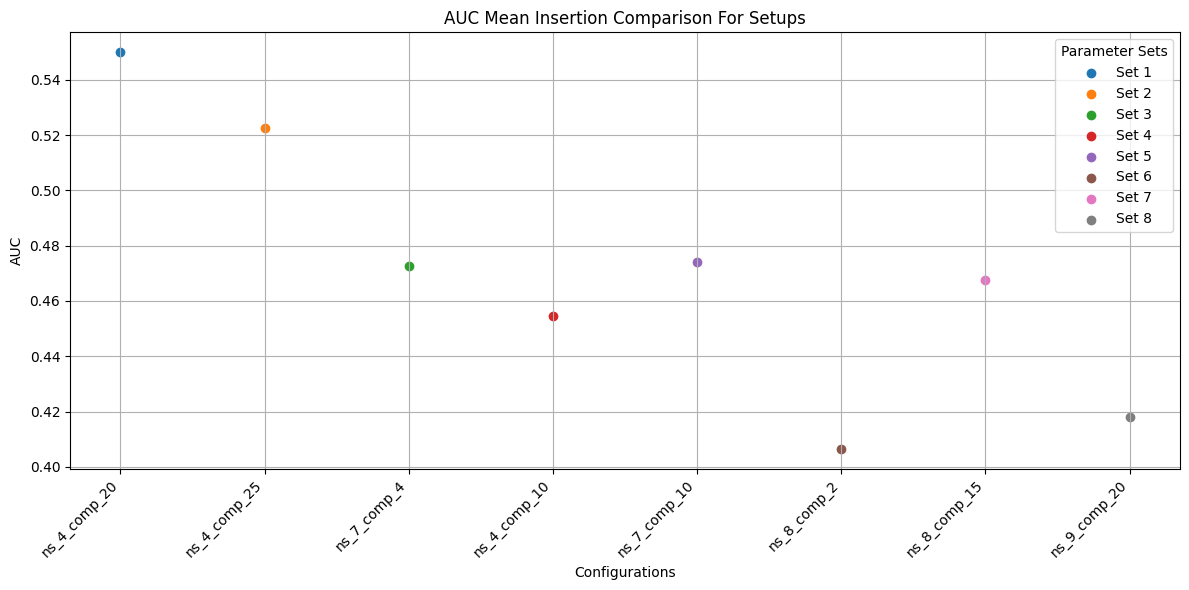

In [56]:
plot_multiple_auc_comparisons(total_auc_insertion, title="AUC Mean Insertion Comparison For Setups")

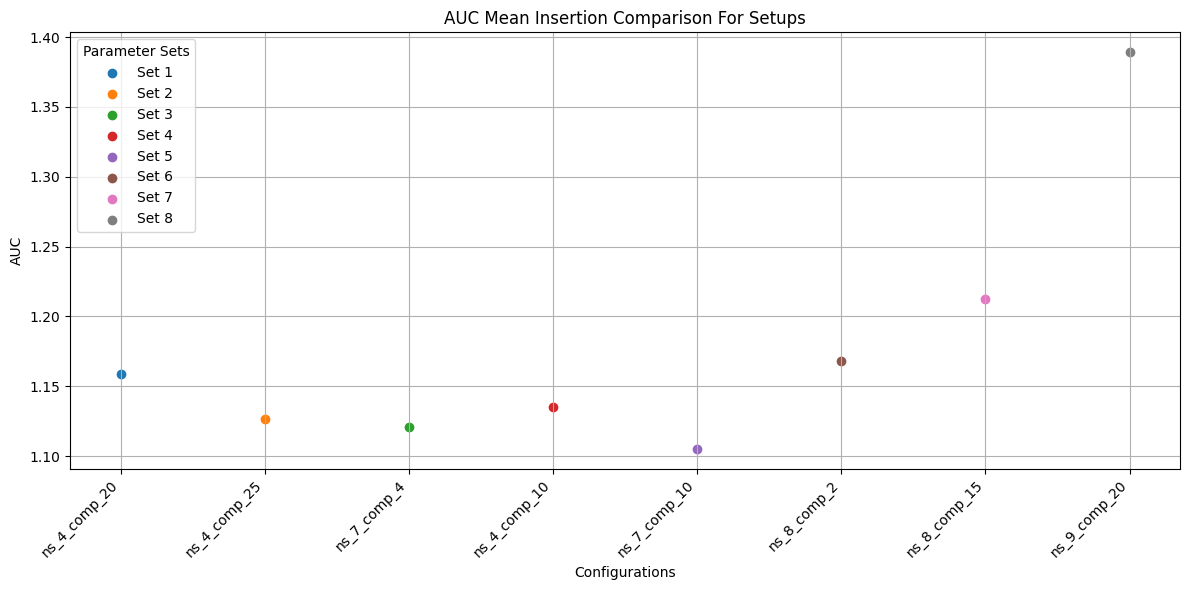

In [58]:
plot_multiple_auc_comparisons(total_auc_deletion, title="AUC Mean Insertion Comparison For Setups")